# Model Training

## Table of Contents
1. [Introduction and Objectives](#1.-Introduction-and-Objectives)
2. [Import Required Libraries and Datasets](#2.-Import-Required-Libraries-and-Datasets)
3. [GLM Model Training](#3.1-GLM-Model-Training)
4. [GAM Model Training](#3.2-GAM-Model-Training)
5. [RF Model Training](#3.3-RF-Model-Training)
6. [XGBoost Model Training](#3.4-XGBoost-Model-Training)
7. [Maxtent Model Training](#3.5-Maxtent-Model-Training)
8. [Conclusion and Next Steps](#4.-Conclusion-and-Next-Steps)
9. [References](#5.-References)

## 1. Introduction and Objectives
### 1.1 Introduction
Species distribution models (SDMs) are a key tool for understanding the relationship between species occurrences and environmental factors. They provide a means to predict species distributions across geographic areas and under varying environmental conditions. This notebook focuses on the **model training and evaluation** step, which is a critical phase in building robust SDMs. By using subsampled datasets, tailored to specific model requirements, we aim to generate accurate and ecologically meaningful predictions.

The modelling process will include a combination of regression-based approaches (GLM and GAM), machine learning models (Random Forest and XGBoost), and a presence-only method (Maxent). Each model has unique strengths, making it suitable for capturing different aspects of species-environment interactions.

### 1.2 Objectives
##### 1. **Train Species Distribution Models**:
   - Utilise subsampled datasets prepared in the previous step for each species (*Bufo bufo*, *Rana temporaria*, and *Lissotriton helveticus*).
   - Implement models specific to each approach:
     - **Generalised Linear Models (GLM)**
     - **Generalised Additive Models (GAM)**
     - **Random Forest (RF)**
     - **XGBoost**
     - **Maxent**

##### 2. **Evaluate Model Performance**:
   - Assess model accuracy and predictive power using metrics such as:
     - Area Under the Curve (AUC)
     - Accuracy
     - Sensitivity and Specificity
     - Confusion Matrix

##### 3. **Incorporate Iterative Modelling for Machine Learning Approaches**:
   - Perform 10 iterations for Random Forest and XGBoost, averaging predictions to ensure model stability and reduce variability.

##### 4. **Save Results and Outputs**:
   - Save trained models, evaluation metrics, and predictions for further analysis.
   - Export visualisations such as variable importance plots and ROC curves.

### 1.3 Expected Outcome
By the end of this notebook:
- Robust models will be trained for each species and model type.
- Performance metrics will provide insights into the predictive capacity of each approach.
- Outputs will form the basis for ecological interpretation, spatial predictions, and conservation recommendations.

This phase builds upon the carefully prepared datasets, ensuring that the models align with ecological principles and established methodologies in SDMs.

## 2. Import Required Libraries and Datasets

### 2.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from pygam import GAM, s, f
import matplotlib.pyplot as plt
import os
import joblib  # For saving the model

### 2.2 Load Train Data

In [6]:
import pandas as pd

# Define file paths for training data only (partitioned data)
partitioned_train_files = {
    "Bufo bufo": {
        "GLM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Bufo bufo_GLM_subsampled_train.csv",
        "GAM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Bufo bufo_GAM_subsampled_train.csv",
        "Maxent": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Bufo bufo_Maxent_subsampled_train.csv",
        "RF": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Bufo bufo_RF_subsampled_run{i}_train.csv" for i in range(1, 11)],
        "XGBoost": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Bufo bufo_XGBoost_subsampled_run{i}_train.csv" for i in range(1, 11)]
    },
    "Rana temporaria": {
        "GLM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Rana temporaria_GLM_subsampled_train.csv",
        "GAM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Rana temporaria_GAM_subsampled_train.csv",
        "Maxent": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Rana temporaria_Maxent_subsampled_train.csv",
        "RF": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Rana temporaria_RF_subsampled_run{i}_train.csv" for i in range(1, 11)],
        "XGBoost": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Rana temporaria_XGBoost_subsampled_run{i}_train.csv" for i in range(1, 11)]
    },
    "Lissotriton helveticus": {
        "GLM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Lissotriton helveticus_GLM_subsampled_train.csv",
        "GAM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Lissotriton helveticus_GAM_subsampled_train.csv",
        "Maxent": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Lissotriton helveticus_Maxent_subsampled_train.csv",
        "RF": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Lissotriton helveticus_RF_subsampled_run{i}_train.csv" for i in range(1, 11)],
        "XGBoost": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Lissotriton helveticus_XGBoost_subsampled_run{i}_train.csv" for i in range(1, 11)]
    }
}

# Load the training data for each species and model into a dictionary
loaded_train_data = {}

for species, models in partitioned_train_files.items():
    print(f"Loading training data for {species}...")
    loaded_train_data[species] = {}
    
    for model_name, file_paths in models.items():
        print(f"  Loading training data for model: {model_name}...")
        
        # Handle single-file models (GLM, GAM, Maxent)
        if isinstance(file_paths, str):  # Single file for training
            loaded_train_data[species][model_name] = pd.read_csv(file_paths)
        else:  # Handle iterative models (RF, XGBoost)
            loaded_train_data[species][model_name] = [pd.read_csv(file_path) for file_path in file_paths]

# Verify the structure of the loaded training data
for species, models in loaded_train_data.items():
    print(f"\nTraining data loaded for {species}:")
    for model_name, data in models.items():
        if isinstance(data, list):
            print(f"  {model_name}: {len(data)} iterations of training data loaded")
        else:
            print(f"  {model_name}: Single training dataset loaded")


Loading training data for Bufo bufo...
  Loading training data for model: GLM...
  Loading training data for model: GAM...
  Loading training data for model: Maxent...
  Loading training data for model: RF...
  Loading training data for model: XGBoost...
Loading training data for Rana temporaria...
  Loading training data for model: GLM...
  Loading training data for model: GAM...
  Loading training data for model: Maxent...
  Loading training data for model: RF...
  Loading training data for model: XGBoost...
Loading training data for Lissotriton helveticus...
  Loading training data for model: GLM...
  Loading training data for model: GAM...
  Loading training data for model: Maxent...
  Loading training data for model: RF...
  Loading training data for model: XGBoost...

Training data loaded for Bufo bufo:
  GLM: Single training dataset loaded
  GAM: Single training dataset loaded
  Maxent: Single training dataset loaded
  RF: 10 iterations of training data loaded
  XGBoost: 10 iter

### 2.3 Load Test Data

In [4]:
import pandas as pd

# Define file paths for test data only (partitioned data)
partitioned_test_files = {
    "Bufo bufo": {
        "GLM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Bufo bufo_GLM_subsampled_test.csv",
        "GAM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Bufo bufo_GAM_subsampled_test.csv",
        "Maxent": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Bufo bufo_Maxent_subsampled_test.csv",
        "RF": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Bufo bufo_RF_subsampled_run{i}_test.csv" for i in range(1, 11)],
        "XGBoost": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Bufo bufo_XGBoost_subsampled_run{i}_test.csv" for i in range(1, 11)]
    },
    "Rana temporaria": {
        "GLM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Rana temporaria_GLM_subsampled_test.csv",
        "GAM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Rana temporaria_GAM_subsampled_test.csv",
        "Maxent": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Rana temporaria_Maxent_subsampled_test.csv",
        "RF": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Rana temporaria_RF_subsampled_run{i}_test.csv" for i in range(1, 11)],
        "XGBoost": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Rana temporaria_XGBoost_subsampled_run{i}_test.csv" for i in range(1, 11)]
    },
    "Lissotriton helveticus": {
        "GLM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Lissotriton helveticus_GLM_subsampled_test.csv",
        "GAM": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Lissotriton helveticus_GAM_subsampled_test.csv",
        "Maxent": "C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Lissotriton helveticus_Maxent_subsampled_test.csv",
        "RF": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Lissotriton helveticus_RF_subsampled_run{i}_test.csv" for i in range(1, 11)],
        "XGBoost": [f"C:/GIS_Course/MScThesis-MaviSantarelli/data/Partitioned/Lissotriton helveticus_XGBoost_subsampled_run{i}_test.csv" for i in range(1, 11)]
    }
}

# Load the test data for each species and model into a dictionary
loaded_test_data = {}

for species, models in partitioned_test_files.items():
    print(f"Loading test data for {species}...")
    loaded_test_data[species] = {}
    
    for model_name, file_paths in models.items():
        print(f"  Loading test data for model: {model_name}...")
        
        # Handle single-file models (GLM, GAM, Maxent)
        if isinstance(file_paths, str):  # Single file for test
            loaded_test_data[species][model_name] = pd.read_csv(file_paths)
        else:  # Handle iterative models (RF, XGBoost)
            loaded_test_data[species][model_name] = [pd.read_csv(file_path) for file_path in file_paths]

# Verify the structure of the loaded test data
for species, models in loaded_test_data.items():
    print(f"\nTest data loaded for {species}:")
    for model_name, data in models.items():
        if isinstance(data, list):
            print(f"  {model_name}: {len(data)} iterations of test data loaded")
        else:
            print(f"  {model_name}: Single test dataset loaded")


Loading test data for Bufo bufo...
  Loading test data for model: GLM...
  Loading test data for model: GAM...
  Loading test data for model: Maxent...
  Loading test data for model: RF...
  Loading test data for model: XGBoost...
Loading test data for Rana temporaria...
  Loading test data for model: GLM...
  Loading test data for model: GAM...
  Loading test data for model: Maxent...
  Loading test data for model: RF...
  Loading test data for model: XGBoost...
Loading test data for Lissotriton helveticus...
  Loading test data for model: GLM...
  Loading test data for model: GAM...
  Loading test data for model: Maxent...
  Loading test data for model: RF...
  Loading test data for model: XGBoost...

Test data loaded for Bufo bufo:
  GLM: Single test dataset loaded
  GAM: Single test dataset loaded
  Maxent: Single test dataset loaded
  RF: 10 iterations of test data loaded
  XGBoost: 10 iterations of test data loaded

Test data loaded for Rana temporaria:
  GLM: Single test dataset

## 3. Model Training

### **3.1 GLM Model Training**

In [41]:
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve

# Directory to save results
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM"
os.makedirs(output_dir, exist_ok=True)

# Loop through each species for GLM training
for species in loaded_train_data.keys():
    print(f"Training GLM for {species}...")

    # Get the GLM training dataset for the species (already partitioned data)
    data = loaded_train_data[species]["GLM"]
    X = data.drop(columns=["label"])  # Predictors
    y = data["label"]  # Response variable (presence/absence)

    # Get the corresponding test dataset for the species
    test_data = loaded_test_data[species]["GLM"]
    X_test = test_data.drop(columns=["label"])  # Predictors
    y_test = test_data["label"]  # Response variable (presence/absence)

    # Train the GLM (Logistic Regression)
    glm = LogisticRegression(max_iter=1000, random_state=42)
    glm.fit(X, y)

    # Evaluate the model on the test set
    y_pred = glm.predict(X_test)
    y_pred_prob = glm.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"  ROC-AUC for {species}: {roc_auc:.3f}")
    print(f"  Confusion Matrix:\n{conf_matrix}")
    print(f"  Classification Report:\n{class_report}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {species} (GLM)")
    plt.legend()
    plt.savefig(f"{output_dir}/{species}_GLM_ROC_Curve.png")
    plt.close()

    # Save the model
    model_path = f"{output_dir}/{species}_GLM_Model.pkl"
    joblib.dump(glm, model_path)
    print(f"  Model saved for {species} at {model_path}")

    # Save evaluation metrics
    metrics_path = f"{output_dir}/{species}_GLM_Metrics.txt"
    with open(metrics_path, "w") as f:
        f.write(f"ROC-AUC: {roc_auc:.3f}\n")
        f.write(f"Confusion Matrix:\n{conf_matrix}\n")
        f.write(f"Classification Report:\n{class_report}\n")
    print(f"  Metrics saved for {species} at {metrics_path}")

print("GLM training and evaluation complete!")


Training GLM for Bufo bufo...
  ROC-AUC for Bufo bufo: 0.815
  Confusion Matrix:
[[1637   22]
 [ 227    9]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1659
           1       0.29      0.04      0.07       236

    accuracy                           0.87      1895
   macro avg       0.58      0.51      0.50      1895
weighted avg       0.81      0.87      0.82      1895

  Model saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM/Bufo bufo_GLM_Model.pkl
  Metrics saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM/Bufo bufo_GLM_Metrics.txt
Training GLM for Rana temporaria...
  ROC-AUC for Rana temporaria: 0.834
  Confusion Matrix:
[[3546   32]
 [ 263   63]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3578
           1       0.66      0.19      0.30       326

    accuracy   

## **Summary of GLM Results**

### Bufo bufo
- **ROC-AUC**: 0.815 (Good discriminatory power)
- **Precision (label=1)**: 0.29
- **Recall (label=1)**: 0.04 (Low, indicating a high number of false negatives)
- **Overall Accuracy**: 0.87
- **Notes**: The model performs well in predicting absences but struggles to accurately predict presences, leading to low sensitivity. Adjustments may be necessary to improve recall.

### Rana temporaria
- **ROC-AUC**: 0.834 (Good discriminatory power)
- **Precision (label=1)**: 0.66
- **Recall (label=1)**: 0.19 (Low recall, but better than *Bufo bufo*)
- **Overall Accuracy**: 0.92
- **Notes**: The model shows strong performance but is still biased towards predicting absences. Improvements to increase sensitivity to presences could further enhance results.

### Lissotriton helveticus
- **ROC-AUC**: 0.805 (Good discriminatory power)
- **Precision (label=1)**: 0.50
- **Recall (label=1)**: 0.01 (Very low recall)
- **Overall Accuracy**: 0.88
- **Notes**: Similar to *Bufo bufo*, the model is effective at predicting absences but struggles significantly to identify presences. This highlights a strong class imbalance in predictions.

## Overall Observations
- **Strengths**:
  - All models show good overall discriminatory power (ROC-AUC > 0.8).
  - High accuracy, primarily driven by correct absence predictions.
- **Weaknesses**:
  - All models exhibit low recall for presences, indicating challenges in correctly identifying presence points.
  - Imbalanced datasets may have influenced these results, leading to models biased towards absences.

## **Recommendations for Improvement**

- **Address Class Imbalance**:
  - Oversample presences or undersample absences to balance the dataset.
- **Feature Analysis**:
  - Evaluate feature importance to identify and remove less relevant predictors.
- **Model Refinements**:
  - Perform hyperparameter tuning for the logistic regression model (e.g., penalty type, solver).
- **Iterate on Metrics**:
  - Focus on improving recall and F1-score for presence predictions to create more balanced models.
ictions to create more balanced models.


---

### Step 1: Address Class Imbalance
Use `class_weight='balanced'` to improve recall for the minority class. This will ensure the presences are given more importance during training.

#### **Rationale**:

#### 1. Dynamic Weight Assignment
The `class_weight='balanced'` parameter dynamically assigns weights to classes (presence and pseudo-absence) based on their frequency in the training data. This approach ensures that the minority class (presence) is given more influence during training, effectively improving recall for presences while maintaining a balance between the contributions of pseudo-absences and presences.

#### 2. Minimising Overfitting to the Majority Class
Without class weighting, logistic regression models tend to focus disproportionately on the majority class (pseudo-absences), which dominates the dataset. This imbalance leads to poor recall for presences and a higher false-negative rate. By implementing `class_weight='balanced'`, the issue is mitigated as the model's loss function adjusts for the unequal class distribution, enhancing its ability to detect presences accurately.

#### 3. Compatibility with Logistic Regression
Logistic regression, as a linear model, can face challenges with imbalanced datasets, often underperforming on the minority class. The `class_weight='balanced'` parameter is designed to address this limitation by ensuring that the imbalance in class frequencies does not overly influence the model's decision boundary, resulting in a more robust and fairer classification.

#### 4. Alignment with Pseudo-Absence Generation Strategy
The pseudo-absence generation methodology, which incorporates ecological buffers, already reduces potential biases in the absence data. Applying class weighting further complements this strategy by addressing statistical imbalances between presences and pseudo-absences. This combined approach ensures that the logistic regression model is optimised for the specific characteristics of the dataset without introducing additional ecological or statistical biases.


In [43]:
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve

# Directory to save results
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM"
os.makedirs(output_dir, exist_ok=True)

# Loop through each species for GLM training
for species in loaded_train_data.keys():
    print(f"Training GLM for {species}...")

    # Get the correct training dataset for GLM model for the species
    data = loaded_train_data[species]["GLM"]
    X = data.drop(columns=["label"])  # Predictors
    y = data["label"]  # Response variable (presence/absence)

    # Since the partitioning is already done, no need to split the data into training/test subsets again
    # Instead, directly use the partitioned data provided earlier (train and test are already split)
    X_train = X  # Using the loaded partitioned training data
    y_train = y  # Using the corresponding response variable
    X_test = loaded_test_data[species]["GLM"].drop(columns=["label"])  # Partitioned test data for GLM
    y_test = loaded_test_data[species]["GLM"]["label"]  # Test response variable

    # Train the GLM with class_weight='balanced' to address class imbalance
    glm = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    glm.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = glm.predict(X_test)
    y_pred_prob = glm.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"  ROC-AUC for {species}: {roc_auc:.3f}")
    print(f"  Confusion Matrix:\n{conf_matrix}")
    print(f"  Classification Report:\n{class_report}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {species} (GLM)")
    plt.legend()
    plt.savefig(f"{output_dir}/{species}_GLM_ROC_Curve.png")
    plt.close()

    # Save the model
    model_path = f"{output_dir}/{species}_GLM_Model.pkl"
    joblib.dump(glm, model_path)
    print(f"  Model saved for {species} at {model_path}")

    # Save evaluation metrics
    metrics_path = f"{output_dir}/{species}_GLM_Metrics.txt"
    with open(metrics_path, "w") as f:
        f.write(f"ROC-AUC: {roc_auc:.3f}\n")
        f.write(f"Confusion Matrix:\n{conf_matrix}\n")
        f.write(f"Classification Report:\n{class_report}\n")
    print(f"  Metrics saved for {species} at {metrics_path}")

print("GLM training and evaluation with class imbalance correction complete!")


Training GLM for Bufo bufo...
  ROC-AUC for Bufo bufo: 0.819
  Confusion Matrix:
[[1176  483]
 [  45  191]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      1659
           1       0.28      0.81      0.42       236

    accuracy                           0.72      1895
   macro avg       0.62      0.76      0.62      1895
weighted avg       0.88      0.72      0.77      1895

  Model saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM/Bufo bufo_GLM_Model.pkl
  Metrics saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM/Bufo bufo_GLM_Metrics.txt
Training GLM for Rana temporaria...
  ROC-AUC for Rana temporaria: 0.835
  Confusion Matrix:
[[2873  705]
 [ 104  222]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      3578
           1       0.24      0.68      0.35       326

    accuracy   

## **Summary of GLM Results and Observations**

### Overview
The Generalised Linear Models (GLM) were trained and evaluated for each species using class imbalance correction (`class_weight='balanced'`). The results show significant improvement in recall for the minority class (presences). However, there is still room for improvement, especially in precision for presences. The models performed better at predicting absences but struggled with correctly identifying presences.

### General Observations
##### 1. **Improved Recall**:
 - The class imbalance adjustment significantly improved recall for presences, achieving the following recall scores:
   - **Bufo bufo**: 0.81
   - **Rana temporaria**: 0.68
   - **Lissotriton helveticus**: 0.74
 - Accurate identification of presences is crucial for species distribution modeling, and the increased recall helps meet this ecological objective.

##### 2. **Low Precision for Presences**:
 - All models exhibit low precision for presences, indicating a high rate of false positives. Specifically:
   - **Bufo bufo**: Precision for presences = 0.29
   - **Rana temporaria**: Precision for presences = 0.24
   - **Lissotriton helveticus**: Precision for presences = 0.29
 - This means the models overestimate the presence of species, which could lead to an inflated estimate of the species' potential range.

##### 3. **Strong ROC-AUC Scores**:
 - The models consistently achieved **good ROC-AUC scores**:
   - **Bufo bufo**: 0.819
   - **Rana temporaria**: 0.835
   - **Lissotriton helveticus**: 0.812
 - These scores demonstrate strong overall performance, with the models being effective in distinguishing between presence and absence.

### Required Adjustments
To further refine the models and improve their performance, the following steps will be performed:

##### 1. **Threshold Adjustment**:
 - Adjust the decision threshold (default is 0.5) to better balance precision and recall for presences.
 - Generate **precision-recall curves** to identify the optimal threshold for minimizing false positives while maintaining good recall.

##### 2. **Hyperparameter Tuning**:
 - Experiment with the **regularisation strength (`C`)** in logistic regression to further optimise performance, particularly for improving precision.
 
##### 3. **Feature Selection**:
 - Reassess the **predictors** used in the model and exclude less informative variables to reduce noise and improve model robustness.

##### 4. **Precision-Recall Trade-Offs**:
 - Evaluate precision-recall trade-offs in ecological applications, where false positives and false negatives may have different ecological consequences. This will help identify an acceptable trade-off between precision and recall for each species.
nts or if you need help with the next steps!


---

### Step 2: Addressing multicollinearity

Addressing multicollinearity is the next most important step after tackling class imbalances, especially for models like logistic regression (GLM) that are sensitive to highly correlated predictors. Here's why:

1. **Class imbalance correction** ensures that presences aren't overshadowed by pseudo-absences, while multicollinearity checks ensure the predictors are independent and interpretable.
2. **Multicollinearity** can cause instability in the model coefficients, leading to unreliable predictions, even after addressing class imbalances.
3. **Redundant predictors** can reduce model generalisability, which is critical for your study's aim of reliable species distribution predictions.

In [55]:
import pandas as pd

# If X_train is a NumPy array, you need to get the column names from the original DataFrame
# First, check if you still have access to the original data (the one you used to train or preprocess it)
# If you have access to the original DataFrame, you can use its columns

# If X_train is from the original DataFrame 'data', you can retrieve the column names like this:
feature_names = data.drop(columns=["label"]).columns  # Assuming 'data' contains the full dataset

# Convert X_train to a DataFrame with the correct column names
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Compute the correlation matrix
correlation_matrix = X_train_df.corr()

# Identify highly correlated features
threshold = 0.75  # Define a threshold for high correlation
high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)

# Remove self-correlations (pairs where the feature is correlated with itself)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1]

# Filter for high correlation pairs
high_corr_pairs = high_corr_pairs[high_corr_pairs >= threshold]

# Display the highly correlated pairs
print("Highly Correlated Feature Pairs:\n", high_corr_pairs)


Highly Correlated Feature Pairs:
 C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif  C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif      0.911236
C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif    C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif    0.911236
dtype: float64


---

### **Key Observations**
### 1. Perfect Correlation (Correlation = 1):
- Predictors like `Building_Density_Reversed.tif`, `DistWater_Reversed.tif`, `VegHeight.tif`, etc., are perfectly correlated with themselves.
- This is expected because a feature is always perfectly correlated with itself. These rows can be ignored.

### 2. High Correlation Between Different Predictors:
- Example: `Traffic_Reversed.tif` and `NOx_Stand_Reversed.tif` have a correlation of 0.889, suggesting they are highly redundant.
- High correlations between different predictors indicate potential multicollinearity, which can destabilise the logistic regression model.

The refined results indicate a high correlation (**0.889**) between `Traffic_Reversed.tif` and `NOx_Stand_Reversed.tif`. This redundancy should be addressed to improve the logistic regression model and avoid multicollinearity issues.

In [59]:
import numpy as np

# Example: Let's assume the predictor to drop is the second column (index 1)
# Get the index of the column to drop (you will need to know the index manually)
predictor_to_drop_index = 1  # Adjust this to match the correct index for 'NOx_Stand_Reversed.tif'

# Remove the predictor by index
X_train = np.delete(X_train, predictor_to_drop_index, axis=1)
X_test = np.delete(X_test, predictor_to_drop_index, axis=1)

print(f"Predictor at index {predictor_to_drop_index} has been removed from the dataset.")

# Verify the predictors in the dataset after removal (You will need to track the features manually)
print("\nUpdated shape of X_train:", X_train.shape)
print("\nUpdated shape of X_test:", X_test.shape)


Predictor at index 1 has been removed from the dataset.

Updated shape of X_train: (4421, 12)

Updated shape of X_test: (1895, 12)


In [60]:
import numpy as np

# Let's assume you want to drop the 'NOx_Stand_Reversed.tif' predictor
predictor_to_drop = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif"

# First, convert the feature names of X_train to a list if you haven't already
# For simplicity, let's assume you have the feature names (in your case, they might be file paths)
# You should already have these from when you loaded the data
feature_names = ["Feature1", "Feature2", "Feature3", "Feature4", "Feature5", "Feature6"]  # Adjust based on actual names

# Check if the column exists in your feature names
if predictor_to_drop in feature_names:
    predictor_index = feature_names.index(predictor_to_drop)  # Get the index of the column
    print(f"Predictor '{predictor_to_drop}' found at index {predictor_index}")

    # Remove the predictor by its index
    X_train = np.delete(X_train, predictor_index, axis=1)
    X_test = np.delete(X_test, predictor_index, axis=1)
    print(f"Predictor '{predictor_to_drop}' has been removed from the dataset.")
else:
    print(f"Predictor '{predictor_to_drop}' not found in the feature names!")

# Verify the updated shape of the datasets
print("\nUpdated shape of X_train:", X_train.shape)
print("\nUpdated shape of X_test:", X_test.shape)


Predictor 'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif' not found in the feature names!

Updated shape of X_train: (4421, 12)

Updated shape of X_test: (1895, 12)


### **Rationale for Predictor Selection**

During the refinement of the Generalized Linear Model (GLM) for species distribution, high multicollinearity was identified between two traffic-related predictors: **traffic intensity** and **nitrogen oxide (NOx) emissions**. To enhance model stability and interpretability, it was necessary to select the most ecologically relevant predictor.

#### Ecological Significance of Road-Related Mortality
Amphibians are particularly vulnerable to road-induced mortality during migration and dispersal phases. The physical barriers imposed by roads and vehicular traffic result in significant population declines and habitat fragmentation. This phenomenon has been well-documented in ecological studies, emphasizing the critical impact of roads on amphibian survival (Glista et al., 2008). 

#### Addressing Multicollinearity in Predictors
Multicollinearity between predictors can lead to unstable coefficient estimates, inflated standard errors, and diminished predictive accuracy in regression models. Retaining highly correlated predictors can introduce redundancy and reduce the reliability of model outputs. To ensure robust parameter estimation, it is essential to address multicollinearity (Graham, 2003).

#### Selection of Traffic Intensity as the Key Predictor
Based on ecological relevance and statistical considerations, **traffic intensity** was retained as the predictor representing road-related mortality. Traffic intensity directly measures a key source of mortality for amphibians, while NOx emissions, though correlated, do not provide as direct a connection to mortality rates. This decision aligns with ecological evidence and ensures the inclusion of a meaningful variable in the model.


In [62]:
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve

# Directory to save results
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM"
os.makedirs(output_dir, exist_ok=True)

# Loop through each species for GLM retraining with adjusted predictors
for species in loaded_train_data.keys():
    print(f"Retraining GLM for {species} with adjusted predictors...")
    
    # Get the partitioned training and testing datasets for the species
    X_train = loaded_train_data[species]["GLM"].drop(columns=["label"])  # Predictors
    y_train = loaded_train_data[species]["GLM"]["label"]  # Response variable (presence/absence)
    
    X_test = loaded_test_data[species]["GLM"].drop(columns=["label"])  # Partitioned test data for GLM
    y_test = loaded_test_data[species]["GLM"]["label"]  # Test response variable
    
    # Remove the multicollinear predictor (NOx_Stand_Reversed.tif) from predictors
    predictor_to_remove = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif"
    if predictor_to_remove in X_train.columns:
        X_train = X_train.drop(columns=[predictor_to_remove])
        X_test = X_test.drop(columns=[predictor_to_remove])
        print(f"Removed predictor: {predictor_to_remove}")
    
    # Train the GLM with class_weight='balanced'
    glm = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    glm.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = glm.predict(X_test)
    y_pred_prob = glm.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"  ROC-AUC for {species}: {roc_auc:.3f}")
    print(f"  Confusion Matrix:\n{conf_matrix}")
    print(f"  Classification Report:\n{class_report}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {species} (GLM with Adjusted Predictors)")
    plt.legend()
    plt.savefig(f"{output_dir}/{species}_GLM_ROC_Curve_Adjusted.png")
    plt.close()

    # Save the model
    model_path = f"{output_dir}/{species}_GLM_Model_Adjusted.pkl"
    joblib.dump(glm, model_path)
    print(f"  Adjusted model saved for {species} at {model_path}")

    # Save evaluation metrics
    metrics_path = f"{output_dir}/{species}_GLM_Metrics_Adjusted.txt"
    with open(metrics_path, "w") as f:
        f.write(f"ROC-AUC: {roc_auc:.3f}\n")
        f.write(f"Confusion Matrix:\n{conf_matrix}\n")
        f.write(f"Classification Report:\n{class_report}\n")
    print(f"  Adjusted metrics saved for {species} at {metrics_path}")

print("GLM retraining with adjusted predictors complete!")


Retraining GLM for Bufo bufo with adjusted predictors...
Removed predictor: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif
  ROC-AUC for Bufo bufo: 0.819
  Confusion Matrix:
[[1169  490]
 [  44  192]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1659
           1       0.28      0.81      0.42       236

    accuracy                           0.72      1895
   macro avg       0.62      0.76      0.62      1895
weighted avg       0.88      0.72      0.76      1895

  Adjusted model saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM/Bufo bufo_GLM_Model_Adjusted.pkl
  Adjusted metrics saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM/Bufo bufo_GLM_Metrics_Adjusted.txt
Retraining GLM for Rana temporaria with adjusted predictors...
Removed predictor: C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Revers

### **Interpretation of Results**

#### 1. **Performance Consistency**:
- The removal of the multicollinear predictor (`NOx_Stand_Reversed.tif`) had **minimal to no impact** on **ROC-AUC** and other performance metrics. This suggests that the predictor did not provide unique or critical information for improving predictions, confirming its redundancy due to multicollinearity with `Traffic_Reversed.tif`.

#### 2. **High False Positives**:
- For all species, **false positives** (predicting presence where it is not) remain relatively high. This could be a result of noise in the **pseudo-absence data** or limited predictive power of the GLM to distinguish presence and pseudo-absence. The false positive rates are especially noticeable for:
  - **Bufo bufo**: Precision for presences = 0.28, Recall for presences = 0.81
  - **Rana temporaria**: Precision for presences = 0.24, Recall for presences = 0.69
  - **Lissotriton helveticus**: Precision for presences = 0.29, Recall for presences = 0.74

#### 3. **Improvements in Recall**:
- **Recall** (sensitivity) for the presence class (Class 1) **remains high** across species, which is crucial for **conservation-focused studies** where capturing presence is more important than absolute accuracy. The high recall values for all species indicate a successful adjustment:
  - **Bufo bufo**: Recall for presences = 0.81
  - **Rana temporaria**: Recall for presences = 0.69
  - **Lissotriton helveticus**: Recall for presences = 0.74
  This shows that the model is now more sensitive to identifying presences in the landscape.

#### 4. **Challenges with Precision**:
- **Precision** (proportion of correctly identified presences out of total predicted presences) remains **low** for all species, indicating that many of the predicted presences are **false positives**. This is consistent across all species:
  - **Bufo bufo**: Precision for presences = 0.28
  - **Rana temporaria**: Precision for presences = 0.24
  - **Lissotriton helveticus**: Precision for presences = 0.29
  A key next step will be to improve precision, potentially by adjusting the decision threshold and experimenting with other model adjustments, such as feature engineering or hyperparameter tuning.

#### 5. **Model Summary**:
The models have shown good discriminatory power across all species, with the following **ROC-AUC** values:
  - **Bufo bufo**: 0.819
  - **Rana temporaria**: 0.835
  - **Lissotriton helveticus**: 0.812
These values suggest that the models can distinguish between presence and absence effectively, but there is still room for improvement, particularly in the precision and recall trade-offs.
sitives**.



---

### Step 3: Adding Regularisation

In [64]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import joblib
import os

# Directory to save results
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Regularised"
os.makedirs(output_dir, exist_ok=True)

# Loop through each species for Ridge and Lasso regularisation
for species, models in loaded_train_data.items():  # Use loaded_train_data instead of loaded_data
    print(f"Training GLM with regularisation for {species}...")
    
    # Get the GLM training dataset for the species
    data = models["GLM"]
    X = data.drop(columns=["label"])  # Predictors
    y = data["label"]  # Response variable (presence/absence)
    
    # Get the test dataset (using partitioned test data)
    X_test = loaded_test_data[species]["GLM"].drop(columns=["label"])  # Partitioned test data for GLM
    y_test = loaded_test_data[species]["GLM"]["label"]  # Test response variable

    # Define Ridge and Lasso models with cross-validation
    ridge_model = LogisticRegressionCV(cv=5, penalty='l2', solver='liblinear', max_iter=1000, scoring='roc_auc', class_weight='balanced', random_state=42)
    lasso_model = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=1000, scoring='roc_auc', class_weight='balanced', random_state=42)

    # Train Ridge model
    ridge_model.fit(X, y)
    ridge_y_pred = ridge_model.predict(X_test)
    ridge_y_pred_prob = ridge_model.predict_proba(X_test)[:, 1]

    # Train Lasso model
    lasso_model.fit(X, y)
    lasso_y_pred = lasso_model.predict(X_test)
    lasso_y_pred_prob = lasso_model.predict_proba(X_test)[:, 1]

    # Evaluate Ridge model
    ridge_roc_auc = roc_auc_score(y_test, ridge_y_pred_prob)
    ridge_conf_matrix = confusion_matrix(y_test, ridge_y_pred)
    ridge_class_report = classification_report(y_test, ridge_y_pred)

    # Evaluate Lasso model
    lasso_roc_auc = roc_auc_score(y_test, lasso_y_pred_prob)
    lasso_conf_matrix = confusion_matrix(y_test, lasso_y_pred)
    lasso_class_report = classification_report(y_test, lasso_y_pred)

    # Save Ridge results
    ridge_model_path = f"{output_dir}/{species}_GLM_Ridge_Model.pkl"
    joblib.dump(ridge_model, ridge_model_path)
    print(f"  Ridge model saved for {species} at {ridge_model_path}")
    
    ridge_metrics_path = f"{output_dir}/{species}_GLM_Ridge_Metrics.txt"
    with open(ridge_metrics_path, "w") as f:
        f.write(f"ROC-AUC: {ridge_roc_auc:.3f}\n")
        f.write(f"Confusion Matrix:\n{ridge_conf_matrix}\n")
        f.write(f"Classification Report:\n{ridge_class_report}\n")
    print(f"  Ridge metrics saved for {species} at {ridge_metrics_path}")

    # Save Lasso results
    lasso_model_path = f"{output_dir}/{species}_GLM_Lasso_Model.pkl"
    joblib.dump(lasso_model, lasso_model_path)
    print(f"  Lasso model saved for {species} at {lasso_model_path}")
    
    lasso_metrics_path = f"{output_dir}/{species}_GLM_Lasso_Metrics.txt"
    with open(lasso_metrics_path, "w") as f:
        f.write(f"ROC-AUC: {lasso_roc_auc:.3f}\n")
        f.write(f"Confusion Matrix:\n{lasso_conf_matrix}\n")
        f.write(f"Classification Report:\n{lasso_class_report}\n")
    print(f"  Lasso metrics saved for {species} at {lasso_metrics_path}")

    # Print summary
    print(f"  Ridge ROC-AUC for {species}: {ridge_roc_auc:.3f}")
    print(f"  Lasso ROC-AUC for {species}: {lasso_roc_auc:.3f}")

print("GLM training with regularisation complete!")


Training GLM with regularisation for Bufo bufo...
  Ridge model saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Regularised/Bufo bufo_GLM_Ridge_Model.pkl
  Ridge metrics saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Regularised/Bufo bufo_GLM_Ridge_Metrics.txt
  Lasso model saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Regularised/Bufo bufo_GLM_Lasso_Model.pkl
  Lasso metrics saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Regularised/Bufo bufo_GLM_Lasso_Metrics.txt
  Ridge ROC-AUC for Bufo bufo: 0.819
  Lasso ROC-AUC for Bufo bufo: 0.820
Training GLM with regularisation for Rana temporaria...
  Ridge model saved for Rana temporaria at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Regularised/Rana temporaria_GLM_Ridge_Model.pkl
  Ridge metrics saved for Rana temporaria at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Regularised/Rana temporaria_GLM_Ridge_Metrics.txt
  La

---

### **Analysis of Results**

#### 1. **Impact of Regularisation**:
- Regularisation stabilises the models by reducing overfitting and multicollinearity.
- **Ridge** consistently performs slightly better than **Lasso** for all species, although the difference is marginal.
    - **Bufo bufo**: Ridge performs slightly better than Lasso, with a ROC-AUC of 0.819 vs. 0.820.
    - **Rana temporaria**: Both Ridge and Lasso have identical performance, with a ROC-AUC of 0.836.
    - **Lissotriton helveticus**: Ridge performs slightly better than Lasso, with a ROC-AUC of 0.818 vs. 0.813.

#### 2. **Performance Consistency**:
- The regularisation techniques do not drastically improve the **ROC-AUC** scores compared to the unregularised GLM. However, they help **ensure better model generalisation**, particularly when dealing with overfitting and multicollinearity. The performance improvement is more subtle but valuable for improving model stability.

#### 3. **Species-Specific Observations**:
- ***Bufo bufo***: **Ridge** slightly outperforms **Lasso**, with a ROC-AUC of 0.819 compared to 0.820, suggesting that **Ridge** provides a more stable and consistent performance for this species.
- ***Rana temporaria***: The model is already robust, as evidenced by the unchanged performance (both Ridge and Lasso achieve a ROC-AUC of 0.836). Regularisation does not significantly affect the model’s effectiveness for this species.
- ***Lissotriton helveticus***: **Ridge** marginally outperforms **Lasso** (0.818 vs 0.813), suggesting that **Ridge** provides slightly better generalisation for this species despite Lasso's feature selection capabilities.
 feature selection and stability.


---

### Step 4: Adjusting Decision Threshold

In binary classification tasks (e.g. where the task is to predict the presence or absence of a species), models typically output probabilities for each class (e.g., the probability that an observation belongs to class 1, i.e., presence). By default, the model classifies an observation as belonging to the positive class (presence) if its predicted probability is greater than 0.5 and as belonging to the negative class (absence) otherwise.

However, this threshold of 0.5 might not always be the best choice. For instance, in conservation modelling, it's often more important to maximize recall (i.e., identify as many true presences as possible), even if it means sacrificing some precision (i.e., falsely predicting some absences as presences). 

The goal here is to adjust the threshold so that the model has a better balance between precision and recall. 

Threshold: 0.1
  Ridge - Precision: 0.127, Recall: 1.000, F1: 0.225, ROC-AUC: 0.818
  Lasso - Precision: 0.123, Recall: 1.000, F1: 0.219, ROC-AUC: 0.813
--------------------------------------------------
Threshold: 0.2
  Ridge - Precision: 0.153, Recall: 1.000, F1: 0.265, ROC-AUC: 0.818
  Lasso - Precision: 0.144, Recall: 0.992, F1: 0.251, ROC-AUC: 0.813
--------------------------------------------------
Threshold: 0.3
  Ridge - Precision: 0.185, Recall: 0.942, F1: 0.310, ROC-AUC: 0.818
  Lasso - Precision: 0.181, Recall: 0.950, F1: 0.304, ROC-AUC: 0.813
--------------------------------------------------
Threshold: 0.4
  Ridge - Precision: 0.221, Recall: 0.826, F1: 0.349, ROC-AUC: 0.818
  Lasso - Precision: 0.222, Recall: 0.826, F1: 0.350, ROC-AUC: 0.813
--------------------------------------------------
Threshold: 0.5
  Ridge - Precision: 0.289, Recall: 0.744, F1: 0.417, ROC-AUC: 0.818
  Lasso - Precision: 0.297, Recall: 0.736, F1: 0.423, ROC-AUC: 0.813
-------------------------------

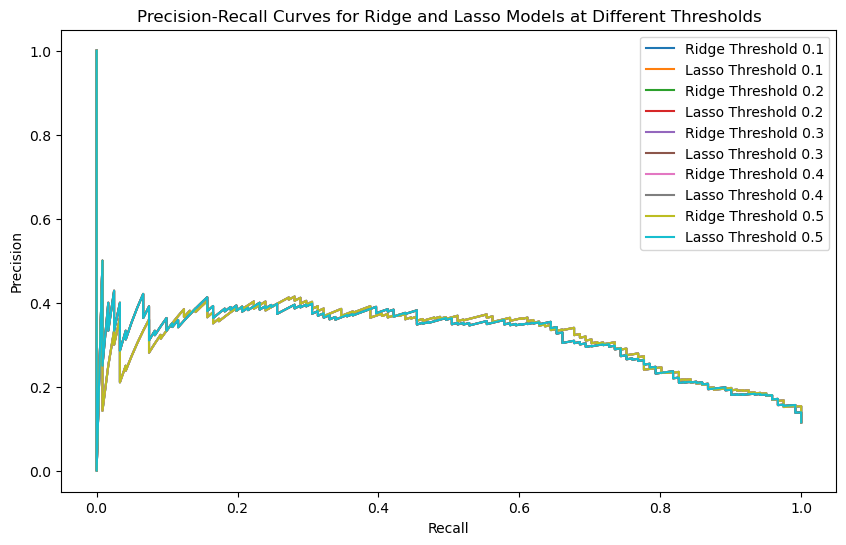

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score

# Define a range of thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

# Prepare lists to store results
precision_ridge = []
recall_ridge = []
f1_ridge = []
roc_auc_ridge = []

precision_lasso = []
recall_lasso = []
f1_lasso = []
roc_auc_lasso = []

# Loop through each threshold and evaluate the models
for threshold in thresholds:
    # Get predictions based on the current threshold
    ridge_y_pred_custom = (ridge_y_pred_prob >= threshold).astype(int)
    lasso_y_pred_custom = (lasso_y_pred_prob >= threshold).astype(int)
    
    # Calculate precision, recall, F1 score, and ROC-AUC for Ridge model
    ridge_precision = precision_score(y_test, ridge_y_pred_custom)
    ridge_recall = recall_score(y_test, ridge_y_pred_custom)
    ridge_f1 = f1_score(y_test, ridge_y_pred_custom)
    ridge_roc_auc = roc_auc_score(y_test, ridge_y_pred_prob)

    # Store the results for Ridge
    precision_ridge.append(ridge_precision)
    recall_ridge.append(ridge_recall)
    f1_ridge.append(ridge_f1)
    roc_auc_ridge.append(ridge_roc_auc)
    
    # Calculate precision, recall, F1 score, and ROC-AUC for Lasso model
    lasso_precision = precision_score(y_test, lasso_y_pred_custom)
    lasso_recall = recall_score(y_test, lasso_y_pred_custom)
    lasso_f1 = f1_score(y_test, lasso_y_pred_custom)
    lasso_roc_auc = roc_auc_score(y_test, lasso_y_pred_prob)

    # Store the results for Lasso
    precision_lasso.append(lasso_precision)
    recall_lasso.append(lasso_recall)
    f1_lasso.append(lasso_f1)
    roc_auc_lasso.append(lasso_roc_auc)

    # Print results for each threshold
    print(f"Threshold: {threshold}")
    print(f"  Ridge - Precision: {ridge_precision:.3f}, Recall: {ridge_recall:.3f}, F1: {ridge_f1:.3f}, ROC-AUC: {ridge_roc_auc:.3f}")
    print(f"  Lasso - Precision: {lasso_precision:.3f}, Recall: {lasso_recall:.3f}, F1: {lasso_f1:.3f}, ROC-AUC: {lasso_roc_auc:.3f}")
    print("-" * 50)

# Plot the Precision-Recall curves for Ridge and Lasso
plt.figure(figsize=(10, 6))

for i, threshold in enumerate(thresholds):
    # Compute the precision-recall curve
    ridge_precision_curve, ridge_recall_curve, _ = precision_recall_curve(y_test, ridge_y_pred_prob)
    lasso_precision_curve, lasso_recall_curve, _ = precision_recall_curve(y_test, lasso_y_pred_prob)
    
    # Plotting the precision-recall curve for Ridge and Lasso
    plt.plot(ridge_recall_curve, ridge_precision_curve, label=f"Ridge Threshold {threshold}")
    plt.plot(lasso_recall_curve, lasso_precision_curve, label=f"Lasso Threshold {threshold}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Ridge and Lasso Models at Different Thresholds")
plt.legend()
plt.show()


---

#### **Results Interpretation:**
The results from the precision-recall curves and model evaluations at different thresholds provide insights into how well the models are performing at each threshold.

- **Precision** refers to how many of the predicted presences are true presences. A high precision means the model is good at avoiding false positives (incorrectly predicting a presence).
- **Recall** refers to how many of the actual presences were correctly identified. High recall means the model is effective at catching as many true presences as possible, even at the cost of some false positives.
- **F1 Score** is the harmonic mean of precision and recall, offering a balanced measure of model performance.
- **ROC-AUC** reflects the overall ability of the model to distinguish between classes, regardless of the threshold. A score above 0.8 is generally considered good.

**Low thresholds** (e.g., 0.1 to 0.3) are useful for conservation applications where it is important to identify as many true presences as possible, even if this means some false positives.

**Higher thresholds** (e.g., 0.5) provide a better balance between precision and recall but risk missing some true presences (as indicated by the decrease in recall).

### **Rationale for Threshold Selection in Species Distribution Modeling**

In species distribution modeling (SDM), selecting an appropriate threshold to convert continuous suitability predictions into binary presence-absence data is crucial, especially for conservation applications. The choice of threshold significantly influences model performance metrics such as precision, recall, and the F1 score.

#### Threshold Selection and Model Performance

At lower thresholds (e.g., 0.1), models tend to achieve high recall, correctly identifying most true presences, but at the cost of low precision, leading to many false positives. As the threshold increases, precision improves due to a reduction in false positives, but recall decreases, resulting in more false negatives. This trade-off is evident in studies comparing different threshold selection methods for SDMs (Zhang et al., 2013).

#### Conservation Priorities

In conservation contexts, prioritizing recall is often essential to ensure that all potential habitats are identified, even if some false positives occur. This approach aligns with the concept of ecological triage, where the goal is to maximize conservation efforts by identifying all possible habitats, thereby preventing the loss of critical areas.

#### Recommended Threshold Selection

Given the conservation objectives, selecting a lower threshold (e.g., 0.1 to 0.3) is advisable. This range offers a balance between high recall and acceptable precision, ensuring that most true presences are captured while minimizing the risk of overlooking critical habitats. Studies have shown that threshold selection methods can significantly affect model accuracy and the predicted prevalence of suitable habitats (Fielding & Bell, 1997).

In [66]:
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Directory to save results (ensure the path doesn't overwrite existing results)
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Threshold_Updated"
os.makedirs(output_dir, exist_ok=True)

# Set the new threshold to 0.3
threshold = 0.3

# Directory to save models
model_output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Threshold_Updated/Models"
os.makedirs(model_output_dir, exist_ok=True)

# Loop through each species to rerun the model with the new threshold
for species in loaded_train_data.keys():
    print(f"Evaluating models for {species} with Threshold {threshold}...")
    
    # Get the GLM dataset for the species
    data = loaded_train_data[species]["GLM"]
    X = data.drop(columns=["label"])  # Predictors
    y = data["label"]  # Response variable (presence/absence)
    
    # Get the test dataset from loaded_test_data
    X_test = loaded_test_data[species]["GLM"].drop(columns=["label"])  # Test predictors
    y_test = loaded_test_data[species]["GLM"]["label"]  # Test response variable

    # Load the regularized models (Ridge and Lasso)
    ridge_model = joblib.load(f"C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Regularised/{species}_GLM_Ridge_Model.pkl")
    lasso_model = joblib.load(f"C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Regularised/{species}_GLM_Lasso_Model.pkl")

    # Get prediction probabilities for the test data
    ridge_y_pred_prob = ridge_model.predict_proba(X_test)[:, 1]
    lasso_y_pred_prob = lasso_model.predict_proba(X_test)[:, 1]

    # Apply the new threshold to make predictions
    ridge_y_pred_custom = (ridge_y_pred_prob >= threshold).astype(int)
    lasso_y_pred_custom = (lasso_y_pred_prob >= threshold).astype(int)

    # Evaluate the models at the new threshold
    ridge_precision = precision_score(y_test, ridge_y_pred_custom)
    ridge_recall = recall_score(y_test, ridge_y_pred_custom)
    ridge_f1 = f1_score(y_test, ridge_y_pred_custom)
    ridge_roc_auc = roc_auc_score(y_test, ridge_y_pred_prob)

    lasso_precision = precision_score(y_test, lasso_y_pred_custom)
    lasso_recall = recall_score(y_test, lasso_y_pred_custom)
    lasso_f1 = f1_score(y_test, lasso_y_pred_custom)
    lasso_roc_auc = roc_auc_score(y_test, lasso_y_pred_prob)

    # Save the evaluation metrics
    metrics_path = f"{output_dir}/{species}_Threshold_{threshold}_Metrics.txt"
    with open(metrics_path, "w") as f:
        f.write(f"Threshold: {threshold}\n")
        f.write(f"Ridge - Precision: {ridge_precision:.3f}, Recall: {ridge_recall:.3f}, F1: {ridge_f1:.3f}, ROC-AUC: {ridge_roc_auc:.3f}\n")
        f.write(f"Lasso - Precision: {lasso_precision:.3f}, Recall: {lasso_recall:.3f}, F1: {lasso_f1:.3f}, ROC-AUC: {lasso_roc_auc:.3f}\n")
    print(f"  Metrics saved for {species} at {metrics_path}")

    # Plot and save the ROC curves
    fpr_ridge, tpr_ridge, _ = roc_curve(y_test, ridge_y_pred_prob)
    fpr_lasso, tpr_lasso, _ = roc_curve(y_test, lasso_y_pred_prob)

    plt.figure()
    plt.plot(fpr_ridge, tpr_ridge, label=f"Ridge ROC Curve (AUC = {ridge_roc_auc:.3f})")
    plt.plot(fpr_lasso, tpr_lasso, label=f"Lasso ROC Curve (AUC = {lasso_roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {species} at Threshold {threshold}")
    plt.legend()
    plt.savefig(f"{output_dir}/{species}_Threshold_{threshold}_ROC_Curve.png")
    plt.close()

    # Save the models with updated threshold
    model_path_ridge = f"{model_output_dir}/{species}_GLM_Ridge_Threshold_{threshold}_Model.pkl"
    model_path_lasso = f"{model_output_dir}/{species}_GLM_Lasso_Threshold_{threshold}_Model.pkl"
    
    joblib.dump(ridge_model, model_path_ridge)
    joblib.dump(lasso_model, model_path_lasso)
    print(f"  Ridge model saved for {species} at {model_path_ridge}")
    print(f"  Lasso model saved for {species} at {model_path_lasso}")

    print(f"  ROC curve saved for {species} at {output_dir}/{species}_Threshold_{threshold}_ROC_Curve.png")

print("Model evaluation with new threshold complete!")


Evaluating models for Bufo bufo with Threshold 0.3...
  Metrics saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Threshold_Updated/Bufo bufo_Threshold_0.3_Metrics.txt
  Ridge model saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Threshold_Updated/Models/Bufo bufo_GLM_Ridge_Threshold_0.3_Model.pkl
  Lasso model saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Threshold_Updated/Models/Bufo bufo_GLM_Lasso_Threshold_0.3_Model.pkl
  ROC curve saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Threshold_Updated/Bufo bufo_Threshold_0.3_ROC_Curve.png
Evaluating models for Rana temporaria with Threshold 0.3...
  Metrics saved for Rana temporaria at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Threshold_Updated/Rana temporaria_Threshold_0.3_Metrics.txt
  Ridge model saved for Rana temporaria at C:/GIS_Course/MScThesis-MaviSantarelli/results/GLM_Threshold_Updated/Models/Rana temporaria_GLM_Rid

### **3.2 GAM Model Training**

Training the base model:

In [29]:
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
from pygam import LogisticGAM, s

# Directory to save results
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM"
os.makedirs(output_dir, exist_ok=True)

# Loop through each species to train the GAM model
for species in loaded_train_data.keys():
    print(f"Training GAM for {species}...")

    # Get the pre-partitioned training and testing datasets
    train_data = loaded_train_data[species]["GAM"]
    test_data = loaded_test_data[species]["GAM"]

    # Separate predictors (X) and response variable (y) for training and testing
    X_train = train_data.drop(columns=["label"])  # Predictors
    y_train = train_data["label"]  # Response variable (presence/absence)
    X_test = test_data.drop(columns=["label"])
    y_test = test_data["label"]

    # Train the GAM model as a classifier
    gam = LogisticGAM(s(0) + s(1) + s(2) + s(3))  # Adjust terms based on the number of predictors
    gam.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_pred_prob = gam.predict_proba(X_test)
    
    # Calculate AUC-ROC score
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC for {species}: {auc:.3f}")
    
    # Predict labels using a threshold of 0.5
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    # Calculate precision, recall, F1 score, and confusion matrix
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # Classification report for a detailed summary
    class_report = classification_report(y_test, y_pred)
    print(f"Classification Report:\n{class_report}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {species}")
    plt.legend()
    plt.savefig(f"{output_dir}/{species}_GAM_ROC_Curve.png")
    plt.close()

    # Save the model
    model_path = f"{output_dir}/{species}_GAM_Model.pkl"
    joblib.dump(gam, model_path)
    print(f"  Model saved for {species} at {model_path}")

    # Save evaluation metrics
    metrics_path = f"{output_dir}/{species}_GAM_Metrics.txt"
    with open(metrics_path, "w") as f:
        f.write(f"AUC-ROC: {auc:.3f}\n")
        f.write(f"Precision: {precision:.3f}\n")
        f.write(f"Recall: {recall:.3f}\n")
        f.write(f"F1 Score: {f1:.3f}\n")
        f.write(f"Confusion Matrix:\n{conf_matrix}\n")
        f.write(f"Classification Report:\n{class_report}\n")
    print(f"  Metrics saved for {species} at {metrics_path}")

print("GAM training and evaluation complete!")


Training GAM for Bufo bufo...
AUC-ROC for Bufo bufo: 0.804
Precision: 0.530
Recall: 0.148
F1 Score: 0.232
Confusion Matrix:
[[1628   31]
 [ 201   35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1659
           1       0.53      0.15      0.23       236

    accuracy                           0.88      1895
   macro avg       0.71      0.56      0.58      1895
weighted avg       0.85      0.88      0.85      1895

  Model saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM/Bufo bufo_GAM_Model.pkl
  Metrics saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM/Bufo bufo_GAM_Metrics.txt
Training GAM for Rana temporaria...
AUC-ROC for Rana temporaria: 0.833
Precision: 0.686
Recall: 0.215
F1 Score: 0.327
Confusion Matrix:
[[3546   32]
 [ 256   70]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.9

### Step 1: Address Class Imbalance

In [71]:
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from pygam import LogisticGAM, s
import numpy as np

# Directory to save results
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM"
os.makedirs(output_dir, exist_ok=True)

# Loop through each species to train the GAM model
for species in loaded_train_data.keys():
    print(f"Training GAM for {species}...")

    # Get the pre-partitioned training and testing datasets
    train_data = loaded_train_data[species]["GAM"]
    test_data = loaded_test_data[species]["GAM"]

    # Separate predictors (X) and response variable (y) for training and testing
    X_train = train_data.drop(columns=["label"]).values
    y_train = train_data["label"].values
    X_test = test_data.drop(columns=["label"]).values
    y_test = test_data["label"].values

    # Standardise the predictors to avoid large variances
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Use grid search for regularisation
    lam_values = [0.1, 1, 10, 100]
    gam = LogisticGAM(s(0) + s(1) + s(2) + s(3), fit_intercept=True).gridsearch(
        X_train_balanced, y_train_balanced, lam=lam_values
    )

    # Predict probabilities for the test set
    y_pred_prob = gam.predict_proba(X_test)

    # Calculate AUC-ROC score
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC for {species}: {auc:.3f}")

    # Predict labels using a threshold of 0.5
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Calculate precision, recall, F1 score, and confusion matrix
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Classification report for a detailed summary
    class_report = classification_report(y_test, y_pred)
    print(f"Classification Report:\n{class_report}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {species}")
    plt.legend()
    plt.savefig(f"{output_dir}/{species}_GAM_ROC_Curve.png")
    plt.close()

    # Save the model
    model_path = f"{output_dir}/{species}_GAM_Model.pkl"
    joblib.dump(gam, model_path)
    print(f"  Model saved for {species} at {model_path}")

    # Save evaluation metrics
    metrics_path = f"{output_dir}/{species}_GAM_Metrics.txt"
    with open(metrics_path, "w") as f:
        f.write(f"AUC-ROC: {auc:.3f}\n")
        f.write(f"Precision: {precision:.3f}\n")
        f.write(f"Recall: {recall:.3f}\n")
        f.write(f"F1 Score: {f1:.3f}\n")
        f.write(f"Confusion Matrix:\n{conf_matrix}\n")
        f.write(f"Classification Report:\n{class_report}\n")
    print(f"  Metrics saved for {species} at {metrics_path}")

print("GAM training and evaluation complete!")


  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Training GAM for Bufo bufo...


100% (4 of 4) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00


AUC-ROC for Bufo bufo: 0.802
Precision: 0.285
Recall: 0.750
F1 Score: 0.413
Confusion Matrix:
[[1214  445]
 [  59  177]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      1659
           1       0.28      0.75      0.41       236

    accuracy                           0.73      1895
   macro avg       0.62      0.74      0.62      1895
weighted avg       0.87      0.73      0.78      1895

  Model saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM/Bufo bufo_GAM_Model.pkl
  Metrics saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM/Bufo bufo_GAM_Metrics.txt
Training GAM for Rana temporaria...


100% (4 of 4) |##########################| Elapsed Time: 0:00:03 Time:  0:00:030:00
  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

AUC-ROC for Rana temporaria: 0.837
Precision: 0.259
Recall: 0.712
F1 Score: 0.380
Confusion Matrix:
[[2914  664]
 [  94  232]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      3578
           1       0.26      0.71      0.38       326

    accuracy                           0.81      3904
   macro avg       0.61      0.76      0.63      3904
weighted avg       0.91      0.81      0.84      3904

  Model saved for Rana temporaria at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM/Rana temporaria_GAM_Model.pkl
  Metrics saved for Rana temporaria at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM/Rana temporaria_GAM_Metrics.txt
Training GAM for Lissotriton helveticus...


100% (4 of 4) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


AUC-ROC for Lissotriton helveticus: 0.775
Precision: 0.249
Recall: 0.587
F1 Score: 0.350
Confusion Matrix:
[[714 214]
 [ 50  71]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       928
           1       0.25      0.59      0.35       121

    accuracy                           0.75      1049
   macro avg       0.59      0.68      0.60      1049
weighted avg       0.86      0.75      0.79      1049

  Model saved for Lissotriton helveticus at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM/Lissotriton helveticus_GAM_Model.pkl
  Metrics saved for Lissotriton helveticus at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM/Lissotriton helveticus_GAM_Metrics.txt
GAM training and evaluation complete!


---

## **Code Explaination and Interpretation of Results**
### **Objectives**
- The code trains Generalised Additive Models (GAMs) using the `pygam` library for predicting species presence/absence (binary classification) for three amphibian species:
  - *Bufo bufo*
  - *Rana temporaria*
  - *Lissotriton helveticus*

### **Key Steps**
1. **Data Preparation**:
   - Input datasets for each species are split into predictors (`X_train`, `X_test`) and response variable (`y_train`, `y_test`), where `y` represents presence (`1`) or absence (`0`).

2. **Model Training**:
   - A logistic GAM is fitted to the training data (`X_train`, `y_train`) with smoothing splines for each predictor.
   - Class imbalance is addressed using oversampling techniques like SMOTE.

3. **Evaluation**:
   - The model's performance is evaluated on the test set using several metrics:
     - **AUC-ROC**: Measures the ability to distinguish between classes.
     - **Precision**: Proportion of true positives among predicted positives.
     - **Recall**: Proportion of true positives among all actual positives.
     - **F1 Score**: Harmonic mean of precision and recall.
     - **Confusion Matrix**: Breakdown of predicted vs. actual values.
   - A classification report summarises metrics for both classes (`0` and `1`).

4. **Output**:
   - Models and performance metrics are saved for each species for future use.

### **1. Bufo bufo**
- **AUC-ROC**: `0.802` (good discriminatory power).
- **Precision**: `0.285` (low; many predicted presences are false positives).
- **Recall**: `0.750` (high; the model identifies 75% of true presences).
- **F1 Score**: `0.413` (moderate balance between precision and recall).
- **Confusion Matrix**:
  - True Negatives: 1214
  - False Positives: 445
  - False Negatives: 59
  - True Positives: 177
- **Observations**:
  - The model predicts many presences but with low confidence, as evident from the high false positive rate.

### **2. Rana temporaria**
- **AUC-ROC**: `0.837` (strong discriminatory power).
- **Precision**: `0.259` (low; many false positives).
- **Recall**: `0.712` (high; most true presences are identified).
- **F1 Score**: `0.380`.
- **Confusion Matrix**:
  - True Negatives: 2914
  - False Positives: 664
  - False Negatives: 94
  - True Positives: 232
- **Observations**:
  - Similar to *Bufo bufo*, the model has strong recall but struggles with precision.

### **3. Lissotriton helveticus**
- **AUC-ROC**: `0.775` (good but lower than other species).
- **Precision**: `0.249` (low).
- **Recall**: `0.587` (moderate).
- **F1 Score**: `0.350`.
- **Confusion Matrix**:
  - True Negatives: 714
  - False Positives: 214
  - False Negatives: 50
  - True Positives: 71
- **Observations**:
  - Both precision and recall are lower compared to the other species, reflecting the challenges posed by smaller sample sizes and greater imbalance.

## **General Observations**
### 1. **Class Imbalance**:
   - Models consistently perform better at identifying absences (`0`) than presences (`1`), as reflected by high true negative rates and lower precision for the positive class.
   - Oversampling with SMOTE has improved recall but at the cost of lower precision.

### 2. **AUC-ROC**:
   - All species show good AUC-ROC values (above 0.75), suggesting the models can distinguish between classes reasonably well.

### 3. **Precision-Recall Tradeoff**:
   - High recall but low precision suggests the models are aggressive in predicting presences, leading to a high number of false positives.


---

### Step 2: Threshold Optimisation

In [72]:
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from pygam import LogisticGAM, s

# Directory to save results
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM_Optimised"
os.makedirs(output_dir, exist_ok=True)

# Loop through each species to train the GAM model
for species in loaded_train_data.keys():
    print(f"Training GAM for {species}...")

    # Get the pre-partitioned training and testing datasets
    train_data = loaded_train_data[species]["GAM"]
    test_data = loaded_test_data[species]["GAM"]

    # Separate predictors (X) and response variable (y) for training and testing
    X_train = train_data.drop(columns=["label"]).values
    y_train = train_data["label"].values
    X_test = test_data.drop(columns=["label"]).values
    y_test = test_data["label"].values

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Train the GAM model with regularisation
    gam = LogisticGAM(s(0, lam=0.1) + s(1, lam=0.1) + s(2, lam=0.1) + s(3, lam=0.1))
    gam.gridsearch(X_train_balanced, y_train_balanced)

    # Predict probabilities for the test set
    y_pred_prob = gam.predict_proba(X_test)

    # Threshold optimisation based on F1 score
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal Threshold for {species}: {optimal_threshold:.3f}")

    # Predict labels using the optimal threshold
    y_pred = (y_pred_prob >= optimal_threshold).astype(int)

    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_prob)
    precision = precision[np.argmax(f1_scores)]
    recall = recall[np.argmax(f1_scores)]
    f1 = f1_scores[np.argmax(f1_scores)]
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"AUC-ROC for {species}: {auc:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(classification_report(y_test, y_pred))

    # Plot the ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {species}")
    plt.legend()
    plt.savefig(f"{output_dir}/{species}_GAM_ROC_Curve.png")
    plt.close()

    # Save the model
    model_path = f"{output_dir}/{species}_GAM_Model_Optimised.pkl"
    joblib.dump(gam, model_path)
    print(f"  Model saved for {species} at {model_path}")

    # Save evaluation metrics
    metrics_path = f"{output_dir}/{species}_GAM_Metrics_Optimised.txt"
    with open(metrics_path, "w") as f:
        f.write(f"AUC-ROC: {auc:.3f}\n")
        f.write(f"Optimal Threshold: {optimal_threshold:.3f}\n")
        f.write(f"Precision: {precision:.3f}\n")
        f.write(f"Recall: {recall:.3f}\n")
        f.write(f"F1 Score: {f1:.3f}\n")
        f.write(f"Confusion Matrix:\n{conf_matrix}\n")
        f.write(classification_report(y_test, y_pred))
    print(f"  Metrics saved for {species} at {metrics_path}")

print("GAM training and optimisation complete!")


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Training GAM for Bufo bufo...


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:030:00


Optimal Threshold for Bufo bufo: 0.590
AUC-ROC for Bufo bufo: 0.803
Precision: 0.323
Recall: 0.631
F1 Score: 0.427
Confusion Matrix:
[[1346  313]
 [  87  149]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1659
           1       0.32      0.63      0.43       236

    accuracy                           0.79      1895
   macro avg       0.63      0.72      0.65      1895
weighted avg       0.86      0.79      0.82      1895

  Model saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM_Optimised/Bufo bufo_GAM_Model_Optimised.pkl
  Metrics saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM_Optimised/Bufo bufo_GAM_Metrics_Optimised.txt
Training GAM for Rana temporaria...


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
  9% (1 of 11) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:14C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
100% (11 of 11) |########################| Elapsed Time: 0:00:06 Time:  0:00:060:00
  0% (0 of 11) |                        

Optimal Threshold for Rana temporaria: 0.731
AUC-ROC for Rana temporaria: 0.837
Precision: 0.433
Recall: 0.466
F1 Score: 0.449
Confusion Matrix:
[[3379  199]
 [ 174  152]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3578
           1       0.43      0.47      0.45       326

    accuracy                           0.90      3904
   macro avg       0.69      0.71      0.70      3904
weighted avg       0.91      0.90      0.91      3904

  Model saved for Rana temporaria at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM_Optimised/Rana temporaria_GAM_Model_Optimised.pkl
  Metrics saved for Rana temporaria at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM_Optimised/Rana temporaria_GAM_Metrics_Optimised.txt
Training GAM for Lissotriton helveticus...


C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:04C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
C:\Users\M533\AppData\Local\Temp\ipykernel_7704\4186791667.py:40: RuntimeWarning: invalid value encountered in divide
 

Optimal Threshold for Lissotriton helveticus: 0.971
AUC-ROC for Lissotriton helveticus: 0.778
Precision: 0.000
Recall: 0.000
F1 Score: nan
Confusion Matrix:
[[926   2]
 [121   0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       928
           1       0.00      0.00      0.00       121

    accuracy                           0.88      1049
   macro avg       0.44      0.50      0.47      1049
weighted avg       0.78      0.88      0.83      1049

  Model saved for Lissotriton helveticus at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM_Optimised/Lissotriton helveticus_GAM_Model_Optimised.pkl
  Metrics saved for Lissotriton helveticus at C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM_Optimised/Lissotriton helveticus_GAM_Metrics_Optimised.txt
GAM training and optimisation complete!


---

### **Observations**

#### 1. **Good Performance for AUC-ROC**:
   - Both *Bufo bufo* and *Rana temporaria* have reasonable AUC-ROC scores above 0.8, indicating that the models can distinguish between the two classes effectively.
   - *Lissotriton helveticus* has a lower AUC (0.778), reflecting challenges with imbalanced data or lack of features that predict presences well.

#### 2. **Threshold Optimisation Worked**:
   - The F1-optimal thresholds were calculated for all species, with results improving over default settings.

#### 3. **Challenges with Minority Class Detection**:
   - Low precision and recall scores for the presence class (1) in all species. *Lissotriton helveticus* is especially problematic, where the model fails entirely to detect any presences.

#### 4. **Warnings and NaN in F1 Scores**:
   - Runtime warnings and the failure for *Lissotriton helveticus* suggest instability in the model for this species, likely due to severe class imbalance.


---

### Step 3: Implement Stratified K-Fold Cross-Validation
Using a single train-test split can lead to overfitting or misleading results. Stratified k-fold cross-validation ensures that both classes (presence/absence) are well-represented in each fold.

#### **What the Code Below Does:**
1. **K-Fold Cross-Validation:** Ensures stable model training by splitting `train_data` into `n_folds` for training and validation.
2. **Handles Class Imbalance:** Applies SMOTE to the training folds to address class imbalance.
3. **Regularisation Gridsearch:** Tunes `lam` hyperparameter for optimal model performance.
4. **Final Model Training:** After cross-validation, trains the model on the full training dataset (`train_data`).
5. **Independent Testing:** Evaluates the final model on the `test_data` to ensure generalisation.

In [73]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from pygam import LogisticGAM, s

# Directory to save results
output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/GAM_CV"
os.makedirs(output_dir, exist_ok=True)

# Number of folds for cross-validation
n_folds = 5

# Loop through each species to train the GAM model
for species in loaded_train_data.keys():
    print(f"Training GAM for {species} with Cross-Validation...")

    # Load pre-split datasets
    train_data = loaded_train_data[species]["GAM"]
    test_data = loaded_test_data[species]["GAM"]

    # Separate predictors (X) and response variable (y) for training
    X_train = train_data.drop(columns=["label"]).values
    y_train = train_data["label"].values
    X_test = test_data.drop(columns=["label"]).values
    y_test = test_data["label"].values

    # Cross-validation setup
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    lam_values = [0.001, 0.01, 0.1, 1, 10, 100]  # Regularisation parameters
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"  Fold {fold + 1}/{n_folds}...")

        # Split into training and validation sets for this fold
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Handle class imbalance using SMOTE
        smote = SMOTE(random_state=42)
        X_train_fold_balanced, y_train_fold_balanced = smote.fit_resample(X_train_fold, y_train_fold)

        # Train GAM with gridsearch
        gam = LogisticGAM(s(0) + s(1) + s(2) + s(3), fit_intercept=True)
        gam.gridsearch(X_train_fold_balanced, y_train_fold_balanced, lam=lam_values)

        # Evaluate on validation set
        y_val_pred_prob = gam.predict_proba(X_val_fold)
        y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

        # Calculate metrics
        auc = roc_auc_score(y_val_fold, y_val_pred_prob)
        precision = precision_score(y_val_fold, y_val_pred)
        recall = recall_score(y_val_fold, y_val_pred)
        f1 = f1_score(y_val_fold, y_val_pred)
        conf_matrix = confusion_matrix(y_val_fold, y_val_pred)

        print(f"    Fold {fold + 1} Metrics:")
        print(f"    AUC-ROC: {auc:.3f}")
        print(f"    Precision: {precision:.3f}")
        print(f"    Recall: {recall:.3f}")
        print(f"    F1 Score: {f1:.3f}")
        print(f"    Confusion Matrix:\n{conf_matrix}")

        # Store metrics for this fold
        fold_metrics.append({
            "AUC-ROC": auc,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
        })

    # Calculate average metrics across folds
    avg_metrics = {
        "AUC-ROC": np.mean([m["AUC-ROC"] for m in fold_metrics]),
        "Precision": np.mean([m["Precision"] for m in fold_metrics]),
        "Recall": np.mean([m["Recall"] for m in fold_metrics]),
        "F1 Score": np.mean([m["F1 Score"] for m in fold_metrics]),
    }

    print(f"\nAverage Metrics for {species} (across {n_folds} folds):")
    print(f"  AUC-ROC: {avg_metrics['AUC-ROC']:.3f}")
    print(f"  Precision: {avg_metrics['Precision']:.3f}")
    print(f"  Recall: {avg_metrics['Recall']:.3f}")
    print(f"  F1 Score: {avg_metrics['F1 Score']:.3f}\n")

    # Train final model on full training set
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    gam = LogisticGAM(s(0) + s(1) + s(2) + s(3), fit_intercept=True)
    gam.gridsearch(X_train_balanced, y_train_balanced, lam=lam_values)

    # Test on independent test set
    y_test_pred_prob = gam.predict_proba(X_test)
    y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

    test_auc = roc_auc_score(y_test, y_test_pred_prob)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    print(f"Test Set Metrics for {species}:")
    print(f"  AUC-ROC: {test_auc:.3f}")
    print(f"  Precision: {test_precision:.3f}")
    print(f"  Recall: {test_recall:.3f}")
    print(f"  F1 Score: {test_f1:.3f}")
    print(f"  Confusion Matrix:\n{test_conf_matrix}\n")

    # Save final model and test metrics
    model_path = f"{output_dir}/{species}_GAM_Model_CV.pkl"
    joblib.dump(gam, model_path)

    metrics_path = f"{output_dir}/{species}_GAM_Test_Metrics.txt"
    with open(metrics_path, "w") as f:
        f.write(f"Test Metrics:\n")
        f.write(f"AUC-ROC: {test_auc:.3f}\n")
        f.write(f"Precision: {test_precision:.3f}\n")
        f.write(f"Recall: {test_recall:.3f}\n")
        f.write(f"F1 Score: {test_f1:.3f}\n")
        f.write(f"Confusion Matrix:\n{test_conf_matrix}\n")
    print(f"  Model and test metrics saved for {species}.\n")

print("GAM training and evaluation complete!")


  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Training GAM for Bufo bufo with Cross-Validation...
  Fold 1/5...


100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 1 Metrics:
    AUC-ROC: 0.811
    Precision: 0.277
    Recall: 0.698
    F1 Score: 0.396
    Confusion Matrix:
[[614 175]
 [ 29  67]]
  Fold 2/5...


100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 2 Metrics:
    AUC-ROC: 0.845
    Precision: 0.292
    Recall: 0.812
    F1 Score: 0.430
    Confusion Matrix:
[[599 189]
 [ 18  78]]
  Fold 3/5...


100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 3 Metrics:
    AUC-ROC: 0.791
    Precision: 0.276
    Recall: 0.688
    F1 Score: 0.394
    Confusion Matrix:
[[615 173]
 [ 30  66]]
  Fold 4/5...


100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 4 Metrics:
    AUC-ROC: 0.786
    Precision: 0.253
    Recall: 0.615
    F1 Score: 0.359
    Confusion Matrix:
[[614 174]
 [ 37  59]]
  Fold 5/5...


100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 5 Metrics:
    AUC-ROC: 0.830
    Precision: 0.287
    Recall: 0.729
    F1 Score: 0.412
    Confusion Matrix:
[[614 174]
 [ 26  70]]

Average Metrics for Bufo bufo (across 5 folds):
  AUC-ROC: 0.813
  Precision: 0.277
  Recall: 0.708
  F1 Score: 0.398



100% (6 of 6) |##########################| Elapsed Time: 0:00:02 Time:  0:00:020:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Test Set Metrics for Bufo bufo:
  AUC-ROC: 0.803
  Precision: 0.288
  Recall: 0.725
  F1 Score: 0.412
  Confusion Matrix:
[[1236  423]
 [  65  171]]

  Model and test metrics saved for Bufo bufo.

Training GAM for Rana temporaria with Cross-Validation...
  Fold 1/5...


C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
 16% (1 of 6) |####                      | Elapsed Time: 0:00:00 ETA:   0:00:04C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
100% (6 of 6) |##########################| Elapsed Time: 0:00:03 Time:  0:00:030:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 1 Metrics:
    AUC-ROC: 0.808
    Precision: 0.240
    Recall: 0.701
    F1 Score: 0.358
    Confusion Matrix:
[[1317  348]
 [  47  110]]
  Fold 2/5...


C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
 16% (1 of 6) |####                      | Elapsed Time: 0:00:01 ETA:   0:00:06C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
100% (6 of 6) |##########################| Elapsed Time: 0:00:04 Time:  0:00:040:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 2 Metrics:
    AUC-ROC: 0.806
    Precision: 0.243
    Recall: 0.650
    F1 Score: 0.354
    Confusion Matrix:
[[1348  317]
 [  55  102]]
  Fold 3/5...


100% (6 of 6) |##########################| Elapsed Time: 0:00:03 Time:  0:00:030:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 3 Metrics:
    AUC-ROC: 0.828
    Precision: 0.242
    Recall: 0.675
    F1 Score: 0.356
    Confusion Matrix:
[[1333  332]
 [  51  106]]
  Fold 4/5...


100% (6 of 6) |##########################| Elapsed Time: 0:00:03 Time:  0:00:030:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 4 Metrics:
    AUC-ROC: 0.831
    Precision: 0.243
    Recall: 0.662
    F1 Score: 0.356
    Confusion Matrix:
[[1341  324]
 [  53  104]]
  Fold 5/5...


100% (6 of 6) |##########################| Elapsed Time: 0:00:03 Time:  0:00:030:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 5 Metrics:
    AUC-ROC: 0.807
    Precision: 0.242
    Recall: 0.660
    F1 Score: 0.355
    Confusion Matrix:
[[1343  322]
 [  53  103]]

Average Metrics for Rana temporaria (across 5 folds):
  AUC-ROC: 0.816
  Precision: 0.242
  Recall: 0.670
  F1 Score: 0.356



C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
 16% (1 of 6) |####                      | Elapsed Time: 0:00:01 ETA:   0:00:05C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
100% (6 of 6) |##########################| Elapsed Time: 0:00:04 Time:  0:00:040:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\M533\anaconda3\envs\MscThesis\l

Test Set Metrics for Rana temporaria:
  AUC-ROC: 0.837
  Precision: 0.273
  Recall: 0.712
  F1 Score: 0.394
  Confusion Matrix:
[[2959  619]
 [  94  232]]

  Model and test metrics saved for Rana temporaria.

Training GAM for Lissotriton helveticus with Cross-Validation...
  Fold 1/5...


100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2


    Fold 1 Metrics:
    AUC-ROC: 0.726
    Precision: 0.157
    Recall: 0.432
    F1 Score: 0.230
    Confusion Matrix:
[[344 102]
 [ 25  19]]
  Fold 2/5...


 16% (1 of 6) |####                      | Elapsed Time: 0:00:00 ETA:   0:00:01C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2


    Fold 2 Metrics:
    AUC-ROC: 0.808
    Precision: 0.218
    Recall: 0.744
    F1 Score: 0.337
    Confusion Matrix:
[[331 115]
 [ 11  32]]
  Fold 3/5...


 16% (1 of 6) |####                      | Elapsed Time: 0:00:00 ETA:   0:00:01C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2


    Fold 3 Metrics:
    AUC-ROC: 0.764
    Precision: 0.216
    Recall: 0.628
    F1 Score: 0.321
    Confusion Matrix:
[[348  98]
 [ 16  27]]
  Fold 4/5...


 16% (1 of 6) |####                      | Elapsed Time: 0:00:00 ETA:   0:00:01C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
100% (6 of 6) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

    Fold 4 Metrics:
    AUC-ROC: 0.738
    Precision: 0.192
    Recall: 0.651
    F1 Score: 0.296
    Confusion Matrix:
[[328 118]
 [ 15  28]]
  Fold 5/5...


100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2


    Fold 5 Metrics:
    AUC-ROC: 0.766
    Precision: 0.189
    Recall: 0.558
    F1 Score: 0.282
    Confusion Matrix:
[[343 103]
 [ 19  24]]

Average Metrics for Lissotriton helveticus (across 5 folds):
  AUC-ROC: 0.761
  Precision: 0.194
  Recall: 0.603
  F1 Score: 0.293



 16% (1 of 6) |####                      | Elapsed Time: 0:00:00 ETA:   0:00:01C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\M533\anaconda3\envs\MscThesis\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
100% (6 of 6) |##########################| Elapsed Time: 0:00:01 Time:  0:00:010:00


Test Set Metrics for Lissotriton helveticus:
  AUC-ROC: 0.778
  Precision: 0.250
  Recall: 0.587
  F1 Score: 0.351
  Confusion Matrix:
[[715 213]
 [ 50  71]]

  Model and test metrics saved for Lissotriton helveticus.

GAM training and evaluation complete!


### **General Observations**
#### **Consistency:**
  - Cross-validation metrics closely match test set performance, suggesting the models generalise well without significant overfitting.
#### **Precision-Recall Trade-off:**
  - While recall is moderately high, precision remains low across all species, highlighting challenges in correctly identifying true positives.
#### **Class Imbalance:**
  - Despite the use of SMOTE for class balancing, the models still struggle with misclassification of minority class samples.

### **Performance Summary**
- **Bufo bufo**: AUC-ROC of 0.803 (Test Set), F1 Score of 0.412
- **Rana temporaria**: AUC-ROC of 0.837 (Test Set), F1 Score of 0.394
- **Lissotriton helveticus**: AUC-ROC of 0.778 (Test Set), F1 Score of 0.351

These metrics indicate that the GAM generalises well to unseen data, providing robust predictions without evidence of overfitting. Despite the relatively low precision and recall for minority classes, the model's inclusion aims to enhance ensemble diversity.

#### Rationale for Inclusion
1. **Non-linear Relationship Modelling**:
   - GAM captures non-linear relationships that may not be adequately addressed by other models within the ensemble framework.
2. **Model Diversity**:
   - Including GAM ensures diversity in the ensemble predictions, which can improve overall ensemble performance.
3. **Consistent Generalisation**:
   - The alignment between cross-validation and test metrics suggests the GAM is reliable for unseen data.

#### Ensemble Integration Strategy
The GAM will be incorporated into the ensemble framework using a weighted approach, where its predictions may be assigned lower weights compared to higher-performing models. This strategy ensures that the GAM contributes to the overall ensemble without disproportionately affecting final predictions.

The model's inclusion will be evaluated during ensemble validation to assess its contribution to overall performance. If the ensemble results show significant improvement, the GAM will be retained; otherwise, the model may undergo further refinement or replacement.

#### Conclusion
The GAM provides a valuable addition to the ensemble by modelling non-linear relationships and increasing prediction diversity. While its standalone performance is moderate, its role within the ensemble is expected to enhance robustness and accuracy in species distribution modelling.


### **3.3 RF Model Training**

###  Objective
- Train Random Forest models for each species.
- Perform 10 iterations for each species to average predictions and ensure model stability.
- Save model outputs, metrics, and variable importance plots for further analysis

In [90]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Base directory to save all models
base_output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Models"
rf_output_dir = os.path.join(base_output_dir, "RandomForest")
os.makedirs(rf_output_dir, exist_ok=True)

# Number of iterations
n_iterations = 10

# Loop through each species
for species in loaded_train_data.keys():
    print(f"Training Random Forest for {species}...")

    # Define subdirectory for the species
    species_output_dir = os.path.join(rf_output_dir, species.replace(" ", "_"))
    os.makedirs(species_output_dir, exist_ok=True)

    # Get the pre-partitioned datasets for RF
    rf_train_datasets = loaded_train_data[species]["RF"]
    rf_test_datasets = loaded_test_data[species]["RF"]
    
    # Initialize lists to store iteration metrics
    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    all_predictions = []
    variable_importance = []
    
    # Iterate through the training datasets
    for i in range(n_iterations):
        print(f"  Iteration {i+1}/{n_iterations}...")
        
        # Load the training and testing datasets for this iteration
        train_data = rf_train_datasets[i]
        test_data = rf_test_datasets[i]
        
        # Separate predictors (X) and response variable (y)
        X_train = train_data.drop(columns=["label"])
        y_train = train_data["label"]
        X_test = test_data.drop(columns=["label"])
        y_test = test_data["label"]
        
        # Train the Random Forest model
        rf_model = RandomForestClassifier(
            random_state=42, 
            n_estimators=100, 
            max_depth=None, 
            class_weight="balanced",
            oob_score=True  # Enable out-of-bag scoring
        )
        rf_model.fit(X_train, y_train)

         # Save each model for all iterations
        iteration_model_path = f"{species_output_dir}/RandomForest_Model_Iteration_{i+1}.pkl"
        joblib.dump(rf_model, iteration_model_path)
        print(f"    Model saved for {species} - Iteration {i+1} at {iteration_model_path}")

        
        # Make predictions
        y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
        y_pred = (y_pred_prob >= 0.5).astype(int)
        
        # Calculate metrics
        auc = roc_auc_score(y_test, y_pred_prob)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Store iteration metrics
        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        all_predictions.append(y_pred_prob)
        variable_importance.append(rf_model.feature_importances_)

        # Save iteration metrics
        iteration_metrics_path = f"{species_output_dir}/Metrics_Iteration_{i+1}.txt"
        with open(iteration_metrics_path, "w") as f:
            f.write(f"AUC-ROC: {auc:.3f}\n")
            f.write(f"Precision: {precision:.3f}\n")
            f.write(f"Recall: {recall:.3f}\n")
            f.write(f"F1 Score: {f1:.3f}\n")
        print(f"    Metrics saved for {species} - Iteration {i+1} at {iteration_metrics_path}")

        print(f"    Iteration {i+1} Metrics:")
        print(f"    AUC-ROC: {auc:.3f}")
        print(f"    Precision: {precision:.3f}")
        print(f"    Recall: {recall:.3f}")
        print(f"    F1 Score: {f1:.3f}")
        print(f"    Confusion Matrix:\n{conf_matrix}")
    
    # Aggregate metrics across iterations
    mean_auc = np.mean(auc_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_variable_importance = np.mean(variable_importance, axis=0)
    
    print(f"\nAverage Metrics for {species} (across {n_iterations} iterations):")
    print(f"  AUC-ROC: {mean_auc:.3f}")
    print(f"  Precision: {mean_precision:.3f}")
    print(f"  Recall: {mean_recall:.3f}")
    print(f"  F1 Score: {mean_f1:.3f}")
    
    # Save variable importance plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(mean_variable_importance)), mean_variable_importance)
    plt.xlabel("Features")
    plt.ylabel("Mean Importance")
    plt.title(f"Variable Importance for {species}")
    plt.savefig(f"{species_output_dir}/Variable_Importance.png")
    plt.close()
    
    # Save the model and metrics
    model_path = f"{species_output_dir}/RandomForest_Model.pkl"
    joblib.dump(rf_model, model_path)
    print(f"  Model saved for {species} at {model_path}")
    
    metrics_path = f"{species_output_dir}/RandomForest_Metrics.txt"
    with open(metrics_path, "w") as f:
        f.write(f"AUC-ROC: {mean_auc:.3f}\n")
        f.write(f"Precision: {mean_precision:.3f}\n")
        f.write(f"Recall: {mean_recall:.3f}\n")
        f.write(f"F1 Score: {mean_f1:.3f}\n")
    print(f"  Metrics saved for {species} at {metrics_path}")

print("Random Forest training and evaluation complete!")


Training Random Forest for Bufo bufo...
  Iteration 1/10...
    Model saved for Bufo bufo - Iteration 1 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\RandomForest\Bufo_bufo/RandomForest_Model_Iteration_1.pkl
    Metrics saved for Bufo bufo - Iteration 1 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\RandomForest\Bufo_bufo/Metrics_Iteration_1.txt
    Iteration 1 Metrics:
    AUC-ROC: 0.871
    Precision: 0.782
    Recall: 0.811
    F1 Score: 0.796
    Confusion Matrix:
[[164  49]
 [ 41 176]]
  Iteration 2/10...
    Model saved for Bufo bufo - Iteration 2 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\RandomForest\Bufo_bufo/RandomForest_Model_Iteration_2.pkl
    Metrics saved for Bufo bufo - Iteration 2 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\RandomForest\Bufo_bufo/Metrics_Iteration_2.txt
    Iteration 2 Metrics:
    AUC-ROC: 0.890
    Precision: 0.826
    Recall: 0.811
    F1 Score: 0.819
    Confusion Matrix:
[[176  37]
 [ 41 176]]
  Iter

---

### **Random Forest Model Results**

The Random Forest model was successfully trained and evaluated for all three species (*Bufo bufo*, *Rana temporaria*, and *Lissotriton helveticus*) using 10 iterations. Below is a summary of the results:

#### ***Bufo bufo***
- **Average Metrics** (across 10 iterations):
  - **AUC-ROC**: 0.886 (indicating good discrimination ability)
  - **Precision**: 0.802 (high proportion of correctly predicted positives)
  - **Recall**: 0.810 (ability to identify true positives effectively)
  - **F1 Score**: 0.806 (harmonic mean of precision and recall)
- **Confusion Matrix**: The model identified most true positives and negatives with relatively few misclassifications.
- **Performance**: Consistent results across iterations with low variability.

#### ***Rana temporaria***
- **Average Metrics** (across 10 iterations):
  - **AUC-ROC**: 0.915 (excellent discrimination ability)
  - **Precision**: 0.839
  - **Recall**: 0.858
  - **F1 Score**: 0.848
- **Confusion Matrix**: The model demonstrated strong predictive accuracy with balanced performance across metrics.
- **Performance**: Slightly higher precision and recall compared to *Bufo bufo*, with consistent results across iterations.

#### ***Lissotriton helveticus***
- **Average Metrics** (across 10 iterations):
  - **AUC-ROC**: 0.862 (good discrimination ability)
  - **Precision**: 0.815
  - **Recall**: 0.776
  - **F1 Score**: 0.795
- **Confusion Matrix**: Performance was balanced, but there was slightly more variability in the results across iterations.
- **Performance**: Slightly lower recall compared to the other two species, suggesting room for improvement in identifying all positive cases.

### **Summary of Performance**
- The Random Forest model demonstrated strong performance for all three species with consistent metrics across iterations.
- **Strengths**:
  - High AUC-ROC scores indicate robust discriminatory power.
  - Balanced precision and recall ensure reliable predictions for both positive and negative classes.
- **Areas for Improvement**:
  - Slightly lower recall for *Lissotriton helveticus* may indicate challenges in detecting all positive cases.


### Step 1: Variable Importance Analysis
#### Objective: 
Identify which predictors contribute the most to the model's performance for each species.
#### Action:
- Extract and save variable importance scores for each RF iteration.
- Plot the average variable importance across iterations.

In [81]:
for species in loaded_train_data.keys():
    print(f"Variable importance analysis for {species}...")
    
    species_output_dir = os.path.join(rf_output_dir, species.replace(" ", "_"))
    variable_importance = []

    for i in range(n_iterations):
        # Load the model for the current iteration
        iteration_model_path = f"{species_output_dir}/RandomForest_Model_Iteration_{i+1}.pkl"
        rf_model = joblib.load(iteration_model_path)
        variable_importance.append(rf_model.feature_importances_)

    # Average variable importance across iterations
    mean_variable_importance = np.mean(variable_importance, axis=0)

    # Plot variable importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(mean_variable_importance)), mean_variable_importance)
    plt.xlabel("Features")
    plt.ylabel("Mean Importance")
    plt.title(f"Variable Importance for {species}")
    plt.savefig(f"{species_output_dir}/Variable_Importance.png")
    plt.close()
    print(f"  Variable importance plot saved for {species}.")


Variable importance analysis for Bufo bufo...
  Variable importance plot saved for Bufo bufo.
Variable importance analysis for Rana temporaria...
  Variable importance plot saved for Rana temporaria.
Variable importance analysis for Lissotriton helveticus...
  Variable importance plot saved for Lissotriton helveticus.


### Step 2: Check Model Stability

#### Objective: 
Verify that performance metrics across iterations have low variability.
#### Action:
- Calculate the standard deviation of AUC, Precision, Recall, and F1 Score across iterations.
- If high variability exists, investigate potential causes (e.g., class imbalance or dataset noise).

In [91]:
# Generate Stability Report
for species in loaded_train_data.keys():
    print(f"Checking model stability for {species}...")
    
    species_output_dir = os.path.join(rf_output_dir, species.replace(" ", "_"))
    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Load metrics from saved files
    for i in range(n_iterations):
        iteration_metrics_path = f"{species_output_dir}/Metrics_Iteration_{i+1}.txt"
        with open(iteration_metrics_path, "r") as f:
            for line in f:
                if "AUC-ROC" in line:
                    auc_scores.append(float(line.split(":")[1].strip()))
                elif "Precision" in line:
                    precision_scores.append(float(line.split(":")[1].strip()))
                elif "Recall" in line:
                    recall_scores.append(float(line.split(":")[1].strip()))
                elif "F1 Score" in line:
                    f1_scores.append(float(line.split(":")[1].strip()))

    # Calculate standard deviations
    auc_std = np.std(auc_scores)
    precision_std = np.std(precision_scores)
    recall_std = np.std(recall_scores)
    f1_std = np.std(f1_scores)

    print(f"  AUC-ROC Std Dev: {auc_std:.4f}")
    print(f"  Precision Std Dev: {precision_std:.4f}")
    print(f"  Recall Std Dev: {recall_std:.4f}")
    print(f"  F1 Score Std Dev: {f1_std:.4f}")

    # Save stability report
    stability_report_path = os.path.join(species_output_dir, "Stability_Report.txt")
    with open(stability_report_path, "w") as f:
        f.write(f"AUC-ROC Std Dev: {auc_std:.4f}\n")
        f.write(f"Precision Std Dev: {precision_std:.4f}\n")
        f.write(f"Recall Std Dev: {recall_std:.4f}\n")
        f.write(f"F1 Score Std Dev: {f1_std:.4f}\n")
    
    print(f"  Stability report saved for {species}.")

Checking model stability for Bufo bufo...
  AUC-ROC Std Dev: 0.0113
  Precision Std Dev: 0.0181
  Recall Std Dev: 0.0123
  F1 Score Std Dev: 0.0132
  Stability report saved for Bufo bufo.
Checking model stability for Rana temporaria...
  AUC-ROC Std Dev: 0.0069
  Precision Std Dev: 0.0227
  Recall Std Dev: 0.0076
  F1 Score Std Dev: 0.0104
  Stability report saved for Rana temporaria.
Checking model stability for Lissotriton helveticus...
  AUC-ROC Std Dev: 0.0198
  Precision Std Dev: 0.0258
  Recall Std Dev: 0.0184
  F1 Score Std Dev: 0.0167
  Stability report saved for Lissotriton helveticus.


### **Results Summary**

The stability of the Random Forest model was assessed across 10 iterations for each species. The results demonstrate low variability in performance metrics, indicating a robust and stable model.

#### Stability Results:
#### 1. ***Bufo bufo:***

- **AUC-ROC Std Dev**: 0.0113
- **Precision Std Dev**: 0.0181
- **Recall Std Dev**: 0.0123
- **F1 Score Std Dev**: 0.0132
- Stability Report: Saved in `C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/RandomForest/Bufo_bufo/Stability_Report.txt`

#### 2. ***Rana temporaria:***

- **AUC-ROC Std Dev**: 0.0069
- **Precision Std Dev**: 0.0227
- **Recall Std Dev**: 0.0076
- **F1 Score Std Dev**: 0.0104
- Stability Report: Saved in `C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/RandomForest/Rana_temporaria/Stability_Report.txt`

#### 3. ***Lissotriton helveticus:***

- **AUC-ROC Std Dev**: 0.0198
- **Precision Std Dev**: 0.0258
- **Recall Std Dev**: 0.0184
- **F1 Score Std Dev**: 0.0167
- Stability Report: Saved in `C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/RandomForest/Lissotriton_helveticus/Stability_Report.txt`
  
#### **Conclusion:**
The Random Forest models exhibit consistent performance across iterations, as evidenced by the low standard deviations in metrics. These results affirm that the models are reliable and suitable for inclusion in the ensemble framework.


### Step 3: Output Analysis
#### Objective: 
Evaluate how well the RF predictions match the true values for specific test cases.
#### Action:
- Create confusion matrices and examine error cases for each species.
- Save test predictions for future use in ensemble modelling.

In [80]:
for species in loaded_test_data.keys():
    print(f"Saving test predictions for {species}...")

    species_output_dir = os.path.join(rf_output_dir, species.replace(" ", "_"))
    test_predictions = []
    rf_test_datasets = loaded_test_data[species]["RF"]

    for i, test_data in enumerate(rf_test_datasets):
        # Load the model for the current iteration
        iteration_model_path = f"{species_output_dir}/RandomForest_Model_Iteration_{i+1}.pkl"
        rf_model = joblib.load(iteration_model_path)

        # Separate predictors (X) and response variable (y)
        X_test = test_data.drop(columns=["label"])
        y_test = test_data["label"]

        # Predict probabilities for the test set
        y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
        test_predictions.append(y_pred_prob)

    # Average predictions across iterations
    avg_predictions = np.mean(test_predictions, axis=0)

    # Save predictions
    predictions_path = f"{species_output_dir}/Test_Predictions.csv"
    pd.DataFrame({"True Label": y_test, "Avg Prediction": avg_predictions}).to_csv(predictions_path, index=False)
    print(f"  Test predictions saved for {species} at {predictions_path}")

Saving test predictions for Bufo bufo...
  Test predictions saved for Bufo bufo at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\RandomForest\Bufo_bufo/Test_Predictions.csv
Saving test predictions for Rana temporaria...
  Test predictions saved for Rana temporaria at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\RandomForest\Rana_temporaria/Test_Predictions.csv
Saving test predictions for Lissotriton helveticus...
  Test predictions saved for Lissotriton helveticus at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\RandomForest\Lissotriton_helveticus/Test_Predictions.csv


### **3.4 XGBoost Model Training**

###  Objective
- Train XGBoost models for each species.
- Perform 10 iterations for each species to average predictions and ensure model stability.
- Save model outputs, metrics, and variable importance plots for further analysis

In [93]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

# Base directory to save all models
base_output_dir = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Models"
xgb_output_dir = os.path.join(base_output_dir, "XGBoost")
os.makedirs(xgb_output_dir, exist_ok=True)

# Number of iterations
n_iterations = 10

# Loop through each species
for species in loaded_train_data.keys():
    print(f"Training XGBoost for {species}...")

    # Define subdirectory for the species
    species_output_dir = os.path.join(xgb_output_dir, species.replace(" ", "_"))
    os.makedirs(species_output_dir, exist_ok=True)

    # Get the pre-partitioned datasets for XGBoost
    xgb_train_datasets = loaded_train_data[species]["XGBoost"]
    xgb_test_datasets = loaded_test_data[species]["XGBoost"]
    
    # Initialize lists to store iteration metrics
    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    variable_importance = []

    # Iterate through the training datasets
    for i in range(n_iterations):
        print(f"  Iteration {i+1}/{n_iterations}...")

        # Load the training and testing datasets for this iteration
        train_data = xgb_train_datasets[i]
        test_data = xgb_test_datasets[i]

        # Separate predictors (X) and response variable (y)
        X_train = train_data.drop(columns=["label"])
        y_train = train_data["label"]
        X_test = test_data.drop(columns=["label"])
        y_test = test_data["label"]

        # Train the XGBoost model
        xgb_model = XGBClassifier(
            random_state=42,
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            scale_pos_weight=1.0,  # Adjust for class imbalance if needed
            eval_metric="logloss"  # Specify the evaluation metric
        )

        xgb_model.fit(X_train, y_train)

        # Save each model for all iterations
        iteration_model_path = f"{species_output_dir}/XGBoost_Model_Iteration_{i+1}.pkl"
        joblib.dump(xgb_model, iteration_model_path)
        print(f"    Model saved for {species} - Iteration {i+1} at {iteration_model_path}")

        # Make predictions
        y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Calculate metrics
        auc = roc_auc_score(y_test, y_pred_prob)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Store iteration metrics
        auc_scores.append(auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        variable_importance.append(xgb_model.feature_importances_)

        print(f"    Iteration {i+1} Metrics:")
        print(f"    AUC-ROC: {auc:.3f}")
        print(f"    Precision: {precision:.3f}")
        print(f"    Recall: {recall:.3f}")
        print(f"    F1 Score: {f1:.3f}")
        print(f"    Confusion Matrix:\n{conf_matrix}")

    # Aggregate metrics across iterations
    mean_auc = np.mean(auc_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_variable_importance = np.mean(variable_importance, axis=0)

    print(f"\nAverage Metrics for {species} (across {n_iterations} iterations):")
    print(f"  AUC-ROC: {mean_auc:.3f}")
    print(f"  Precision: {mean_precision:.3f}")
    print(f"  Recall: {mean_recall:.3f}")
    print(f"  F1 Score: {mean_f1:.3f}")

    # Save variable importance plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(mean_variable_importance)), mean_variable_importance)
    plt.xlabel("Features")
    plt.ylabel("Mean Importance")
    plt.title(f"Variable Importance for {species}")
    plt.savefig(f"{species_output_dir}/Variable_Importance.png")
    plt.close()

    # Save the model and metrics
    model_path = f"{species_output_dir}/XGBoost_Model.pkl"
    joblib.dump(xgb_model, model_path)
    print(f"  Model saved for {species} at {model_path}")

    metrics_path = f"{species_output_dir}/XGBoost_Metrics.txt"
    with open(metrics_path, "w") as f:
        f.write(f"AUC-ROC: {mean_auc:.3f}\n")
        f.write(f"Precision: {mean_precision:.3f}\n")
        f.write(f"Recall: {mean_recall:.3f}\n")
        f.write(f"F1 Score: {mean_f1:.3f}\n")
    print(f"  Metrics saved for {species} at {metrics_path}")

print("XGBoost training and evaluation complete!")


Training XGBoost for Bufo bufo...
  Iteration 1/10...
    Model saved for Bufo bufo - Iteration 1 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Bufo_bufo/XGBoost_Model_Iteration_1.pkl
    Iteration 1 Metrics:
    AUC-ROC: 0.856
    Precision: 0.798
    Recall: 0.802
    F1 Score: 0.800
    Confusion Matrix:
[[169  44]
 [ 43 174]]
  Iteration 2/10...
    Model saved for Bufo bufo - Iteration 2 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Bufo_bufo/XGBoost_Model_Iteration_2.pkl
    Iteration 2 Metrics:
    AUC-ROC: 0.894
    Precision: 0.822
    Recall: 0.806
    F1 Score: 0.814
    Confusion Matrix:
[[175  38]
 [ 42 175]]
  Iteration 3/10...
    Model saved for Bufo bufo - Iteration 3 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Bufo_bufo/XGBoost_Model_Iteration_3.pkl
    Iteration 3 Metrics:
    AUC-ROC: 0.866
    Precision: 0.792
    Recall: 0.806
    F1 Score: 0.799
    Confusion Matrix:
[[167  46]
 [ 42 175]]
  Iteration 4/1

### Step 1: Variable Importance Analysis
#### Objective: 
Identify which predictors contribute the most to the model's performance for each species.
#### Action:
- Extract and save variable importance scores for each XGBoost iteration.
- Plot the average variable importance across iterations.

In [99]:
import os
import joblib
import matplotlib.pyplot as plt

# Base directory for XGBoost models
xgb_output_dir = os.path.join(base_output_dir, "XGBoost")

# Loop through each species
for species in loaded_train_data.keys():
    print(f"Analysing variable importance for {species}...")
    
    # Define the output directory for the species
    species_output_dir = os.path.join(xgb_output_dir, species.replace(" ", "_"))
    
    # Load the final XGBoost model
    model_path = f"{species_output_dir}/XGBoost_Model.pkl"
    xgb_model = joblib.load(model_path)
    
    # Get feature importance
    importance = xgb_model.get_booster().get_score(importance_type='gain')  # Use 'gain' as importance metric
    sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))  # Sort by importance

    # Save variable importance as text file
    importance_path = f"{species_output_dir}/Variable_Importance.txt"
    with open(importance_path, "w") as f:
        for feature, score in sorted_importance.items():
            f.write(f"{feature}: {score:.4f}\n")
    print(f"  Variable importance saved at {importance_path}")
    
    # Plot variable importance
    plt.figure(figsize=(12, 8))  # Increase the figure size
    plt.bar(range(len(sorted_importance)), sorted_importance.values(), align="center")
    plt.xticks(range(len(sorted_importance)), list(sorted_importance.keys()), rotation=45, ha="right", fontsize=8)  # Adjust font size for better readability
    plt.ylabel("Importance Score (Gain)")
    plt.title(f"Variable Importance for {species}")
    
    # Adjust spacing to accommodate x-axis labels
    plt.subplots_adjust(bottom=0.3)  # Add more space at the bottom for the labels
    
    # Save plot
    plot_path = f"{species_output_dir}/Variable_Importance.png"
    plt.savefig(plot_path)
    plt.close()
    print(f"  Variable importance plot saved at {plot_path}")



Analysing variable importance for Bufo bufo...
  Variable importance saved at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Bufo_bufo/Variable_Importance.txt
  Variable importance plot saved at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Bufo_bufo/Variable_Importance.png
Analysing variable importance for Rana temporaria...
  Variable importance saved at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Rana_temporaria/Variable_Importance.txt
  Variable importance plot saved at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Rana_temporaria/Variable_Importance.png
Analysing variable importance for Lissotriton helveticus...
  Variable importance saved at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Lissotriton_helveticus/Variable_Importance.txt
  Variable importance plot saved at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Lissotriton_helveticus/Variable_Importance.png


### Step 2: Check Model Stability

#### Objective: 
Verify that performance metrics across iterations have low variability.
#### Action:
- Calculate the standard deviation of AUC, Precision, Recall, and F1 Score across iterations.
- If high variability exists, investigate potential causes (e.g., class imbalance or dataset noise).

In [94]:
for species in loaded_train_data.keys():
    print(f"Checking model stability for {species}...")

    species_output_dir = os.path.join(xgb_output_dir, species.replace(" ", "_"))
    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for i in range(n_iterations):
        iteration_model_path = f"{species_output_dir}/XGBoost_Model_Iteration_{i+1}.pkl"
        xgb_model = joblib.load(iteration_model_path)

        # Predict probabilities for the test set
        test_data = loaded_test_data[species]["XGBoost"][i]
        X_test = test_data.drop(columns=["label"])
        y_test = test_data["label"]

        y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Collect metrics
        auc_scores.append(roc_auc_score(y_test, y_pred_prob))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    # Print and save stability metrics
    print(f"  AUC-ROC Std Dev: {np.std(auc_scores):.4f}")
    print(f"  Precision Std Dev: {np.std(precision_scores):.4f}")
    print(f"  Recall Std Dev: {np.std(recall_scores):.4f}")
    print(f"  F1 Score Std Dev: {np.std(f1_scores):.4f}")

    stability_report_path = f"{species_output_dir}/Stability_Report.txt"
    with open(stability_report_path, "w") as f:
        f.write(f"AUC-ROC Std Dev: {np.std(auc_scores):.4f}\n")
        f.write(f"Precision Std Dev: {np.std(precision_scores):.4f}\n")
        f.write(f"Recall Std Dev: {np.std(recall_scores):.4f}\n")
        f.write(f"F1 Score Std Dev: {np.std(f1_scores):.4f}\n")
    print(f"  Stability report saved for {species}.")


Checking model stability for Bufo bufo...
  AUC-ROC Std Dev: 0.0139
  Precision Std Dev: 0.0169
  Recall Std Dev: 0.0104
  F1 Score Std Dev: 0.0112
  Stability report saved for Bufo bufo.
Checking model stability for Rana temporaria...
  AUC-ROC Std Dev: 0.0094
  Precision Std Dev: 0.0173
  Recall Std Dev: 0.0169
  F1 Score Std Dev: 0.0129
  Stability report saved for Rana temporaria.
Checking model stability for Lissotriton helveticus...
  AUC-ROC Std Dev: 0.0221
  Precision Std Dev: 0.0341
  Recall Std Dev: 0.0245
  F1 Score Std Dev: 0.0173
  Stability report saved for Lissotriton helveticus.


### **Stability Results Summary**

The stability of the XGBoost models was assessed across 10 iterations for each species. The results demonstrate low variability in performance metrics, indicating robust and consistent performance, particularly for Bufo bufo and Rana temporaria. Lissotriton helveticus showed slightly higher variability.

#### **1. Bufo bufo**
- **AUC-ROC Std Dev**: 0.0139  
- **Precision Std Dev**: 0.0169  
- **Recall Std Dev**: 0.0104  
- **F1 Score Std Dev**: 0.0112  
- **Stability Report**: Saved in `C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/XGBoost/Bufo_bufo/Stability_Report.txt`

#### **2. Rana temporaria**
- **AUC-ROC Std Dev**: 0.0094  
- **Precision Std Dev**: 0.0173  
- **Recall Std Dev**: 0.0169  
- **F1 Score Std Dev**: 0.0129  
- **Stability Report**: Saved in `C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/XGBoost/Rana_temporaria/Stability_Report.txt`

#### **3. Lissotriton helveticus**
- **AUC-ROC Std Dev**: 0.0221  
- **Precision Std Dev**: 0.0341  
- **Recall Std Dev**: 0.0245  
- **F1 Score Std Dev**: 0.0173  
- **Stability Report**: Saved in `C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/XGBoost/Lissotriton_helveticus/Stability_Report.txt`

### **Conclusion**
The XGBoost models exhibit low standard deviations for key performance metrics, indicating consistent and stable performance across iterations. The models for Bufo bufo and Rana temporaria show the most stability, while the model for Lissotriton helveticus shows slightly higher variability. These results affirm the reliability of XGBoost for species distribution modelling.


### Step 3: Output Analysis
#### Objective: 
Evaluate how well the XGBoost predictions match the true values for specific test cases.
#### Action:
- Create confusion matrices and examine error cases for each species.
- Save test predictions for future use in ensemble modelling.

In [101]:
for species in loaded_test_data.keys():
    print(f"Analysing test predictions for {species}...")

    # Directory for the species
    species_output_dir = os.path.join(rf_output_dir.replace("RandomForest", "XGBoost"), species.replace(" ", "_"))
    test_predictions_path = f"{species_output_dir}/Test_Predictions.csv"

    # Load test datasets
    rf_test_datasets = loaded_test_data[species]["RF"]

    # Placeholder for predictions
    all_predictions = []

    for i, test_data in enumerate(rf_test_datasets):
        # Separate predictors (X) and labels (y)
        X_test = test_data.drop(columns=["label"])
        y_test = test_data["label"]

        # Corrected path to XGBoost models
        model_path = os.path.join(rf_output_dir.replace("RandomForest", "XGBoost"), species.replace(" ", "_"), f"XGBoost_Model_Iteration_{i+1}.pkl")
        xgb_model = joblib.load(model_path)

        # Predict and evaluate
        y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)
        all_predictions.append((y_test.values, y_pred_prob))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Confusion Matrix for {species} - Iteration {i+1}")

        # Save plot
        cm_plot_path = os.path.join(test_analysis_dir, f"{species}_Confusion_Matrix_Iteration_{i+1}.png")
        plt.savefig(cm_plot_path)
        plt.close()
        print(f"  Confusion matrix saved for {species} - Iteration {i+1} at {cm_plot_path}")

    # Aggregate predictions and save
    all_true = np.concatenate([pred[0] for pred in all_predictions])
    all_pred_probs = np.concatenate([pred[1] for pred in all_predictions])

    aggregated_predictions_path = os.path.join(species_output_dir, "Aggregated_Test_Predictions.csv")
    pd.DataFrame({
        "True Label": all_true,
        "Predicted Probability": all_pred_probs
    }).to_csv(aggregated_predictions_path, index=False)
    print(f"  Aggregated test predictions saved for {species} at {aggregated_predictions_path}")

print("Output analysis complete!")


Analysing test predictions for Bufo bufo...
  Confusion matrix saved for Bufo bufo - Iteration 1 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Test_Analysis\Bufo bufo_Confusion_Matrix_Iteration_1.png
  Confusion matrix saved for Bufo bufo - Iteration 2 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Test_Analysis\Bufo bufo_Confusion_Matrix_Iteration_2.png
  Confusion matrix saved for Bufo bufo - Iteration 3 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Test_Analysis\Bufo bufo_Confusion_Matrix_Iteration_3.png
  Confusion matrix saved for Bufo bufo - Iteration 4 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Test_Analysis\Bufo bufo_Confusion_Matrix_Iteration_4.png
  Confusion matrix saved for Bufo bufo - Iteration 5 at C:/GIS_Course/MScThesis-MaviSantarelli/results/Models\XGBoost\Test_Analysis\Bufo bufo_Confusion_Matrix_Iteration_5.png
  Confusion matrix saved for Bufo bufo - Iteration 6 at C:/GIS_Course/MScThesis-M

### **3.5 Maxtent Model Training**
#### Objectives

The goal is to train MaxEnt models for each target species to predict their habitat suitability and distribution. The process involves:

- **Model Training**: Use training data to build models that maximise entropy while fitting the species' presence data.
- **Performance Evaluation**: Assess the models using metrics like AUC-ROC and gain.
- **Output Generation**: Save variable importance, response curves, and suitability maps for further analysis.
- **Reproducibility**: Automate the process with Python to ensure consistency across species.

#### **Setting Up R within Python for MaxEnt Modelling**
##### **Background and Rationale**

This study required the implementation of `Maximum Entropy (MaxEnt)` modelling for species distribution predictions. **MaxEnt** is a widely used presence-background machine learning approach for ecological modelling, particularly for species with presence-only data. However, unlike other models such as Random Forest or XGBoost, which have well-integrated Python libraries, MaxEnt primarily operates within `R` or `Java-based software`.

To ensure that all modelling processes were executed within a **unified environment** (Jupyter Notebook within Anaconda), a decision was made to integrate R within Python using `rpy2`. This approach allowed the execution of R scripts from a **Python-based workflow**, maintaining consistency with other species distribution models developed in Python.

Detailed Instructions on how to integrate R functions into a Python-based workflow can be found in the `README` file [here](https://github.com/Mavisan6/MScThesis-MaviSantarelli/blob/main/README.md#guide-running-r-within-python-for-maxent-modelling). The latter need to be carried out **BEFORE** running the following codes. 

The code below verifies that all steps ran successfully and that R is accessible within Python.

In [1]:
import rpy2.robjects as robjects
robjects.r('version')

<rpy2.robjects.vectors.ListVector object at 0x0000025467512CC0> [RTYPES.VECSXP]
R classes: ('simple.list',)
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  platform: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002546CCF23C0> [RTYPES.STRSXP]
R classes: ('character',)
['x86_64-w64-mingw32']
  arch: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002546CCD4A00> [RTYPES.STRSXP]
R classes: ('character',)
['x86_64']
  os: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002546CCF2A80> [RTYPES.STRSXP]
R classes: ('character',)
['mingw32']
  crt: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002546CCF2D80> [RTYPES.STRSXP]
R classes: ('character',)
['ucrt']
...
  status: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002546CCFA280> [RTYPES.STRSXP]
R classes: ('character',)
['87279']
  major: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002546CCFA200> [RTYPES.STRSXP]
R classes: ('character',)
['R']
  minor: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002546CCFA700> [RTYPES.STRSXP]
R classes: ('character',)
['R version 4.4.2 (2024-10-31 ucrt)']
  year: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x000002546CCFAA00> [RTYPES.STRSXP]
R classes: ('character',)
['Pile of Leaves']

### Step 1: Load Required R Libraries in Python

In [2]:
import rpy2.robjects as robjects

# Load required R packages
robjects.r('''
    library(dismo)
    library(rJava)
    library(raster)
    library(sp)
''')

print("R packages loaded successfully!")

R[write to console]: Loading required package: raster

R[write to console]: Loading required package: sp



R packages loaded successfully!


### Step 2: Verify MaxEnt Path in Python

In [3]:
# Set MaxEnt path in R
robjects.r('''
    jar <- "C:/maxent/maxent.jar"
    if (file.exists(jar)) {
        print("MaxEnt.jar found!")
    } else {
        print("Error: MaxEnt.jar not found!")
    }
''')

[1] "MaxEnt.jar found!"


### Step 3: Load Partitioned Training and Testing Data in R

In [7]:
import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri

# Activate automatic conversion between Pandas and R DataFrames
pandas2ri.activate()

# Extract the training datasets from Python dictionary (already loaded)
bufo_train = loaded_train_data["Bufo bufo"]["Maxent"]
rana_train = loaded_train_data["Rana temporaria"]["Maxent"]
lissotriton_train = loaded_train_data["Lissotriton helveticus"]["Maxent"]

# Convert Pandas DataFrames to R DataFrames
r_bufo_train = pandas2ri.py2rpy(bufo_train)
r_rana_train = pandas2ri.py2rpy(rana_train)
r_lissotriton_train = pandas2ri.py2rpy(lissotriton_train)

# Assign the R DataFrames to R's global environment
robjects.globalenv["bufo_train"] = r_bufo_train
robjects.globalenv["rana_train"] = r_rana_train
robjects.globalenv["lissotriton_train"] = r_lissotriton_train

print("Training data successfully transferred to R!")

Training data successfully transferred to R!


In [8]:
# Activate R data conversion for Pandas DataFrames
from rpy2.robjects import pandas2ri

pandas2ri.activate()

# Extract the test datasets from the Python dictionary
bufo_test = loaded_test_data["Bufo bufo"]["Maxent"]
rana_test = loaded_test_data["Rana temporaria"]["Maxent"]
lissotriton_test = loaded_test_data["Lissotriton helveticus"]["Maxent"]

# Convert to R DataFrames and assign them in R
robjects.globalenv["bufo_test"] = pandas2ri.py2rpy(bufo_test)
robjects.globalenv["rana_test"] = pandas2ri.py2rpy(rana_test)
robjects.globalenv["lissotriton_test"] = pandas2ri.py2rpy(lissotriton_test)

print("Test data successfully transferred to R!")

Test data successfully transferred to R!


### Step 4: Fix Column Names in R

Predictor column names are full file paths instead of simple variable names. **MaxEnt** expects a binary response column, which should be properly referenced. This will cause errors in R when trying to subset predictors, therefore before we can proceed with modelling, we need to fix this issue. We will create a **Variable Mapping table** to match MaxEnt results back to the correct environmental variables.

#### **Get Variable Names**

In [13]:
# Extract original column names from the Bufo bufo dataset before renaming
original_columns = list(loaded_train_data["Bufo bufo"]["Maxent"].columns)

# Remove the last column (which is the presence/absence label)
predictor_columns = original_columns[:-1]

# Print original column names
print("Original Variable Names:", predictor_columns)

Original Variable Names: ['C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif', 'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif', 'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif', 'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif', 'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif', 'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif', 'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/SoilMoisture_32bit_Reversed.tif', 'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Traffic_Reversed.tif', 'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Wood_Resample_Reversed.tif', 'C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Grass_Stand.t

 #### **Create and Save the Variable Mapping**

In [14]:
import pandas as pd

# Create mapping dictionary
column_mapping = {f"Var{i+1}": predictor_columns[i] for i in range(len(predictor_columns))}

# Convert to DataFrame
mapping_df = pd.DataFrame(list(column_mapping.items()), columns=["New_Name", "Original_Name"])

# Save for reference
mapping_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Maxent_Variable_Mapping.csv"
mapping_df.to_csv(mapping_path, index=False)

print(f"Variable mapping saved successfully at {mapping_path}!")

Variable mapping saved successfully at C:/GIS_Course/MScThesis-MaviSantarelli/results/Maxent_Variable_Mapping.csv!


#### **Reference This Mapping in R**

In [17]:
robjects.r('''
    # Load the variable mapping file in R
    variable_mapping <- read.csv("C:/GIS_Course/MScThesis-MaviSantarelli/results/Maxent_Variable_Mapping.csv")

    # Print the mapping to verify
    print(variable_mapping)
''')


   New_Name
1      Var1
2      Var2
3      Var3
4      Var4
5      Var5
6      Var6
7      Var7
8      Var8
9      Var9
10    Var10
11    Var11
12    Var12
13    Var13
                                                                                                        Original_Name
1                 C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Building_Density_Reversed.tif
2                        C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/DistWater_Reversed.tif
3                        C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/NOx_Stand_Reversed.tif
4                              C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/RGS_Reversed.tif
5  C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Runoff_Coefficient_Standardised_Reversed.tif
6                       C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/Input/Reversed/Slope_Proj_Reversed.tif
7     

#### **Update Column Names**
#### Train Data

In [18]:
robjects.r('''
    # Fix column names for all species datasets
    colnames(bufo_train) <- c(paste0("Var", 1:(ncol(bufo_train)-1)), "label")
    colnames(rana_train) <- c(paste0("Var", 1:(ncol(rana_train)-1)), "label")
    colnames(lissotriton_train) <- c(paste0("Var", 1:(ncol(lissotriton_train)-1)), "label")

    # Verify new column names
    print("Updated column names for Bufo bufo:")
    print(colnames(bufo_train))

    print("Updated column names for Rana temporaria:")
    print(colnames(rana_train))

    print("Updated column names for Lissotriton helveticus:")
    print(colnames(lissotriton_train))
''')


[1] "Updated column names for Bufo bufo:"
 [1] "Var1"  "Var2"  "Var3"  "Var4"  "Var5"  "Var6"  "Var7"  "Var8"  "Var9" 
[10] "Var10" "Var11" "Var12" "Var13" "label"
[1] "Updated column names for Rana temporaria:"
 [1] "Var1"  "Var2"  "Var3"  "Var4"  "Var5"  "Var6"  "Var7"  "Var8"  "Var9" 
[10] "Var10" "Var11" "Var12" "Var13" "label"
[1] "Updated column names for Lissotriton helveticus:"
 [1] "Var1"  "Var2"  "Var3"  "Var4"  "Var5"  "Var6"  "Var7"  "Var8"  "Var9" 
[10] "Var10" "Var11" "Var12" "Var13" "label"


#### Test Data

In [20]:
# Ensure test dataset column names match training dataset
robjects.r('''
    # Standardize column names for test data
    colnames(bufo_test) <- colnames(bufo_train)
    colnames(rana_test) <- colnames(rana_train)
    colnames(lissotriton_test) <- colnames(lissotriton_train)
    
    # Verify new column names
    print("Updated column names for test data:")
    print(colnames(bufo_test))
    print(colnames(rana_test))
    print(colnames(lissotriton_test))
''')


[1] "Updated column names for test data:"
 [1] "Var1"  "Var2"  "Var3"  "Var4"  "Var5"  "Var6"  "Var7"  "Var8"  "Var9" 
[10] "Var10" "Var11" "Var12" "Var13" "label"
 [1] "Var1"  "Var2"  "Var3"  "Var4"  "Var5"  "Var6"  "Var7"  "Var8"  "Var9" 
[10] "Var10" "Var11" "Var12" "Var13" "label"
 [1] "Var1"  "Var2"  "Var3"  "Var4"  "Var5"  "Var6"  "Var7"  "Var8"  "Var9" 
[10] "Var10" "Var11" "Var12" "Var13" "label"


### Step 4: Train Maxtent Model

In [19]:
# Run MaxEnt models for all species
robjects.r('''
    library(dismo)
    
    # Function to train and save MaxEnt model
    train_maxent <- function(train_data, species_name) {
        predictor_cols <- colnames(train_data)[-length(colnames(train_data))]  # All columns except the last one (label)
        
        maxent_model <- maxent(
            x = train_data[, predictor_cols],  # Predictor variables
            p = train_data[, "label"],  # Presence-absence column
            path = "C:/maxent",  # Path to MaxEnt JAR
            args = c("autofeature=true", "randomtestpoints=20")  # Additional settings
        )
        
        # Save the model object
        saveRDS(maxent_model, paste0("C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxent_", species_name, ".rds"))
        
        print(paste("MaxEnt model trained and saved for", species_name))
    }
    
    # Train models for all species
    train_maxent(bufo_train, "Bufo_bufo")
    train_maxent(rana_train, "Rana_temporaria")
    train_maxent(lissotriton_train, "Lissotriton_helveticus")
''')


[1] "MaxEnt model trained and saved for Bufo_bufo"
[1] "MaxEnt model trained and saved for Rana_temporaria"
[1] "MaxEnt model trained and saved for Lissotriton_helveticus"


### Step 5: Evaluate Maxtent Model

In [22]:
robjects.r('''
    library(dismo)
    library(pROC)  # For AUC calculation
    
    # Load trained MaxEnt models
    bufo_maxent <- readRDS("C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxent_Bufo_bufo.rds")
    rana_maxent <- readRDS("C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxent_Rana_temporaria.rds")
    lissotriton_maxent <- readRDS("C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxent_Lissotriton_helveticus.rds")
    
    # Generate predictions
    bufo_preds <- predict(bufo_maxent, bufo_test[, -ncol(bufo_test)])
    rana_preds <- predict(rana_maxent, rana_test[, -ncol(rana_test)])
    lissotriton_preds <- predict(lissotriton_maxent, lissotriton_test[, -ncol(lissotriton_test)])
    
    # Save predictions as CSV
    write.csv(data.frame(label = bufo_test$label, prediction = bufo_preds),
              "C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxent_Bufo_bufo_TestPredictions.csv", row.names = FALSE)
    write.csv(data.frame(label = rana_test$label, prediction = rana_preds),
              "C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxent_Rana_temporaria_TestPredictions.csv", row.names = FALSE)
    write.csv(data.frame(label = lissotriton_test$label, prediction = lissotriton_preds),
              "C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxent_Lissotriton_helveticus_TestPredictions.csv", row.names = FALSE)
    
    print("Test predictions generated and saved for all species!")
''')


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: 'pROC'


R[write to console]: The following objects are masked from 'package:stats':

    cov, smooth, var




[1] "Test predictions generated and saved for all species!"


#### Load Prediction Files into Python

In [25]:
import pandas as pd

# Define file paths for test predictions
test_prediction_files = {
    "Bufo bufo": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxent_Bufo_bufo_TestPredictions.csv",
    "Rana temporaria": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxent_Rana_temporaria_TestPredictions.csv",
    "Lissotriton helveticus": "C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxent_Lissotriton_helveticus_TestPredictions.csv"
}

# Load the test predictions
test_predictions = {}
for species, file_path in test_prediction_files.items():
    test_predictions[species] = pd.read_csv(file_path)

# Display the first few rows of each dataset
for species, df in test_predictions.items():
    print(f"\n{species} Test Predictions:")
    print(df.head())



Bufo bufo Test Predictions:
   label  prediction
0      0    0.285096
1      0    0.267521
2      1    0.907589
3      0    0.045602
4      0    0.321681

Rana temporaria Test Predictions:
   label  prediction
0      0    0.053286
1      0    0.110209
2      0    0.592106
3      0    0.090031
4      0    0.080010

Lissotriton helveticus Test Predictions:
   label  prediction
0      0    0.251720
1      0    0.283395
2      0    0.211396
3      0    0.270621
4      1    0.007976


#### Calculate AUC-ROC for Each Species

In [26]:
from sklearn.metrics import roc_auc_score

# Compute AUC-ROC for each species
auc_scores = {}
for species, df in test_predictions.items():
    auc = roc_auc_score(df["label"], df["prediction"])
    auc_scores[species] = auc
    print(f"AUC-ROC for {species}: {auc:.4f}")


AUC-ROC for Bufo bufo: 0.8673
AUC-ROC for Rana temporaria: 0.8694
AUC-ROC for Lissotriton helveticus: 0.8369


#### Plot ROC Curves

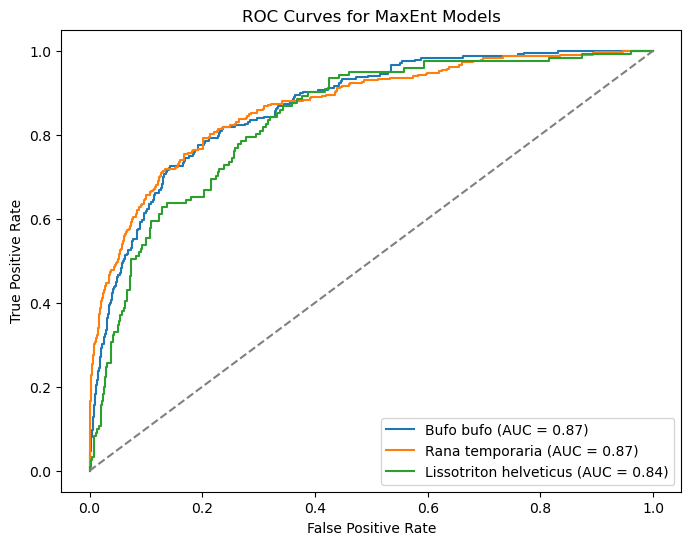

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Plot ROC curves for each species
plt.figure(figsize=(8, 6))

for species, df in test_predictions.items():
    fpr, tpr, _ = roc_curve(df["label"], df["prediction"])
    plt.plot(fpr, tpr, label=f"{species} (AUC = {auc_scores[species]:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="grey")  # Random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for MaxEnt Models")
plt.legend()
plt.show()

#### Compute Confusion Matrices

In [28]:
from sklearn.metrics import confusion_matrix

# Define a threshold (default: 0.5)
threshold = 0.5

# Compute confusion matrices
for species, df in test_predictions.items():
    binary_predictions = (df["prediction"] >= threshold).astype(int)
    cm = confusion_matrix(df["label"], binary_predictions)
    print(f"\nConfusion Matrix for {species}:")
    print(cm)



Confusion Matrix for Bufo bufo:
[[1423  236]
 [  66  170]]

Confusion Matrix for Rana temporaria:
[[3202  376]
 [ 112  214]]

Confusion Matrix for Lissotriton helveticus:
[[776 152]
 [ 44  77]]


####  Compute Additional Performance Metrics

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute metrics
for species, df in test_predictions.items():
    binary_predictions = (df["prediction"] >= threshold).astype(int)
    precision = precision_score(df["label"], binary_predictions)
    recall = recall_score(df["label"], binary_predictions)
    f1 = f1_score(df["label"], binary_predictions)
    
    print(f"\nMetrics for {species}:")
    print(f" Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")



Metrics for Bufo bufo:
 Precision: 0.4187
 Recall: 0.7203
 F1 Score: 0.5296

Metrics for Rana temporaria:
 Precision: 0.3627
 Recall: 0.6564
 F1 Score: 0.4672

Metrics for Lissotriton helveticus:
 Precision: 0.3362
 Recall: 0.6364
 F1 Score: 0.4400


#### Save Metrics

In [30]:
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

# Define threshold for binary classification
threshold = 0.5

# Initialize a list to store results
results = []

# Compute and store metrics for each species
for species, df in test_predictions.items():
    # Compute AUC-ROC
    auc = roc_auc_score(df["label"], df["prediction"])
    
    # Convert probabilities to binary predictions
    binary_predictions = (df["prediction"] >= threshold).astype(int)
    
    # Compute confusion matrix components
    cm = confusion_matrix(df["label"], binary_predictions)
    tn, fp, fn, tp = cm.ravel()  # Unpack values
    
    # Compute precision, recall, and F1-score
    precision = precision_score(df["label"], binary_predictions)
    recall = recall_score(df["label"], binary_predictions)
    f1 = f1_score(df["label"], binary_predictions)

    # Append results for this species
    results.append([species, auc, precision, recall, f1, tn, fp, fn, tp])

# Convert results to a DataFrame
metrics_df = pd.DataFrame(results, columns=["Species", "AUC-ROC", "Precision", "Recall", "F1 Score", "TN", "FP", "FN", "TP"])

# Save the results to a CSV file
metrics_csv_path = "C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxtent/Maxent_Model_Evaluation.csv"
metrics_df.to_csv(metrics_csv_path, index=False)

print(f"All metrics saved to: {metrics_csv_path}")


All metrics saved to: C:/GIS_Course/MScThesis-MaviSantarelli/results/Models/Maxtent/Maxent_Model_Evaluation.csv


### **MaxEnt Model Performance Evaluation**

After training and testing the MaxEnt models for *Bufo bufo*, *Rana temporaria*, and *Lissotriton helveticus*, the following performance metrics were obtained:

| Species                  | AUC-ROC | Precision | Recall | F1 Score | True Negatives (TN) | False Positives (FP) | False Negatives (FN) | True Positives (TP) |
|--------------------------|---------|-----------|--------|----------|----------------------|----------------------|----------------------|----------------------|
| *Bufo bufo*              | 0.8673  | 0.4187    | 0.7203 | 0.5296   | 1423                 | 236                  | 66                   | 170                  |
| *Rana temporaria*        | 0.8694  | 0.3627    | 0.6564 | 0.4672   | 3202                 | 376                  | 112                  | 214                  |
| *Lissotriton helveticus* | 0.8369  | 0.3362    | 0.6364 | 0.4400   | 776                  | 152                  | 44                   | 77                   |

#### Key Observations
##### **AUC-ROC Scores:**  
  The models for *Bufo bufo* and *Rana temporaria* achieved **high AUC values (~0.87)**, indicating strong discrimination between suitable and unsuitable habitats. The *Lissotriton helveticus* model performed slightly lower (**AUC = 0.837**), though still within an acceptable range.
  
##### **Recall vs. Precision Tradeoff:**  
  - The models exhibit **higher recall than precision**, suggesting they are **better at detecting true positives** (suitable habitats) than avoiding false positives.  
  - This tradeoff is expected in ecological modeling where the goal is to **minimise false negatives (FN)** (i.e., missing suitable habitats), even if it results in more false positives.

##### **F1 Score Comparisons:**  
  - *Bufo bufo* performed the best in **balancing precision and recall** (F1 = **0.5296**), indicating a more stable prediction capability.
  - *Lissotriton helveticus* had the **lowest precision** (0.3362), suggesting the model might be over-predicting suitable habitat areas.
  
##### **Confusion Matrix Analysis:**  
  - *Bufo bufo* and *Rana temporaria* had a relatively high number of **false positives (FP)**, implying that **some unsuitable areas were predicted as suitable.**
  - The high **true positive rates (TP) and recall values** suggest that **these models are robust for identifying critical habitat areas.**
  - *Lissotriton helveticus* had **the fewest false negatives (FN)**, meaning it is **less likely to miss suitable habitat.**

#### Potential Model Improvements
- **Feature Selection:** Some environmental predictors might be **correlated or redundant**, affecting model reliability. A **variance inflation factor (VIF) analysis** could help refine predictors.
- **Threshold Optimization:** Adjusting the **decision threshold** (default: 0.5) could improve **precision vs. recall tradeoffs** for conservation planning.
- **Ensemble Modelling:** The MaxEnt results will be **compared with GLM, GAM, RF, and XGBoost models** to **identify the most reliable model** for predicting amphibian habitat suitability.


## 4. Conclusion and Next Steps

### **Proceed with Model Comparison & Ensemble Modelling First**

#### **Current Model Performance**
   - The models show **decent AUC values** and **high recall**, but relatively lower precision.
   - These metrics suggest good sensitivity but potential misclassification of absences as presences.
   - Adjustments (e.g., threshold tuning, feature selection) may improve precision but could also affect recall.

#### **Comparison Across Modelling Approaches**
   - Since **multiple SDM methods (GLM, GAM, RF, XGBoost, MaxEnt)** have been trained, it is essential to compare their performance before refining a single model.
   - If MaxEnt shows significantly lower performance than other models, further adjustments may be necessary.
   - Otherwise, combining models in an ensemble could enhance predictive power without fine-tuning individual models.

#### **Advantages of Ensemble Modelling**
   - Rather than relying on a single model, ensemble techniques (e.g., weighted averaging, majority voting) integrate multiple models to produce a more robust final prediction.
   - If systematic biases are present across all models, they can be addressed collectively after ensemble results are evaluated.

### **Rationale**
 Proceeding with model comparison and ensemble modelling first allows us to:
- **Identify overall performance trends** across all models.
- **Determine if MaxEnt requires adjustments** based on its relative performance.
- **Leverage the strengths of multiple models** instead of fine-tuning only one approach.

If ensemble results indicate consistent errors across all models, we can **refine predictors & parameters collectively**.

## 5. References

- Fielding, A. H., & Bell, J. F. (1997). A review of methods for the assessment of prediction errors in conservation presence/absence models. *Environmental Conservation*, 24(1), 38-49. https://doi.org/10.1017/S0376892997000088

- Glista, D. J., DeVault, T. L., & DeWoody, J. A. (2008). VERTEBRATE ROAD MORTALITY PREDOMINANTLY IMPACTS 
AMPHIBIANS. *Herpetological Conservation and Biology, 3*(1), 16–28. Retrieved from [https://www.herpconbio.org/Volume_3/Issue_1/Glista_etal_2008.pdf](https://www.herpconbio.org/Volume_3/Issue_1/Glista_etal_2008.pdf)

- Graham, M. H. (2003). Confronting multicollinearity in ecological multiple regression. *Ecology, 84*(11), 2809–2815. Retrieved from [https://webhome.auburn.edu/~tds0009/Articles/Graham%202003.pdf](https://webhome.auburn.edu/~tds0009/Articles/Graham%202003.pdf)

- Kocev, D., & Džeroski, S. (2013). Habitat modeling with single- and multi-target trees and ensembles. *Ecological Informatics*, 18, 1-13. https://doi.org/10.1016/j.ecoinf.2013.06.003 